## Imports

In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import sem, t
from scipy import mean

import warnings
warnings.filterwarnings('ignore')

import pickle

## Genotype & Phenotype Simulation

In [2]:
#Simulate Genotype
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    
    assert(len(G) == samples_n)
    assert(len(G[0])== loci_m)
    return G

In [3]:
G= simulate_genotype(10,5)
print(G)

[[-0.65465367 -0.60302269 -0.14285714  0.18569534  0.        ]
 [-0.65465367 -0.60302269 -0.14285714  0.18569534 -1.11803399]
 [-0.65465367 -0.60302269 -0.14285714 -1.67125804  1.11803399]
 [-0.65465367 -0.60302269  1.28571429  0.18569534  1.11803399]
 [-0.65465367  0.90453403 -0.14285714  0.18569534  1.11803399]
 [ 1.52752523 -0.60302269  1.28571429  2.04264872 -1.11803399]
 [-0.65465367 -0.60302269 -1.57142857  0.18569534  1.11803399]
 [-0.65465367  2.41209076  1.28571429 -1.67125804 -1.11803399]
 [ 1.52752523  0.90453403 -1.57142857  0.18569534 -1.11803399]
 [ 1.52752523 -0.60302269 -0.14285714  0.18569534  0.        ]]


### Set beta and envi noise

In [4]:
#Provide beta_g, e_noise and get G with genotype & Phenotype data
def simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise):
    G = simulate_genotype(samples_n, loci_m)
    #print(G)
    loci =random.randint(0,loci_m-1)
    #print(loci)
    SNP = G[:,loci]
    individuals = len(SNP)
    b_i = beta_g
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a e_j(noise) value
        e_j = np.random.normal(0, e_noise)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    G = np.append(G, Y_n, axis=1)
    return G, loci

#Provide var_g, var_e and get G with genotype & Phenotype data
def simulate_genotype_and_phenotype_var(samples_n, loci_m,var_g,var_e):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    G = np.append(G, Y_n, axis=1)
    return G, loci

In [8]:
G, loci = simulate_genotype_and_phenotype_set(10, 5, 1,0)
print(loci)
print(G)

4
[[ 0.         -1.52752523 -1.08347268  0.46852129  0.5         0.5       ]
 [ 0.          0.65465367  1.32424438 -1.09321633  0.5         0.5       ]
 [ 0.         -1.52752523 -1.08347268  0.46852129 -2.         -2.        ]
 [ 0.         -1.52752523  0.12038585  0.46852129  0.5         0.5       ]
 [ 0.          0.65465367  0.12038585 -1.09321633 -2.         -2.        ]
 [ 0.          0.65465367 -1.08347268  0.46852129  0.5         0.5       ]
 [ 0.          0.65465367  1.32424438 -1.09321633  0.5         0.5       ]
 [ 0.          0.65465367  1.32424438  2.0302589   0.5         0.5       ]
 [ 0.          0.65465367 -1.08347268 -1.09321633  0.5         0.5       ]
 [ 0.          0.65465367  0.12038585  0.46852129  0.5         0.5       ]]


# Machine Learning Models

## Random Forest Regression & SHAP 

In [18]:
def shap_RFR_tree_train(G, values = 'limit'):
    X = G[:,0:len(G[0])-1]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    forReg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50)
    forReg.fit(x_train, y_train)
    y_predict = forReg.predict(X)
    print("Y predict")
    print(y_predict)
    shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
    if values == 'all':
        return shap_values, x_train, x_test, y_train, y_test, y_predict, forReg
    elif values == 'limit':
        return shap_values, x_train

    
def shap_feature_plot_RFR(shap_values, x_train):
    shap.summary_plot(shap_values, x_train, plot_type="bar")

## Calculate SHAP

In [6]:
def mean_shap_values(shap_values):
    '''
    if len(shap_values) == 2:
        mean_shap = [0] * len(shap_values[0][0])
        for shap_value in shap_values[0]:
            for x in range(0, len(shap_value)):
                mean_shap[x] = mean_shap[x] + abs(shap_value[x])
        for x in range(0, len(shap_values[0])):
            mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
    else:    
        mean_shap = [0] * len(shap_values[0])
        for shap_value in shap_values:
            for x in range(0, len(shap_value)):
                mean_shap[x] = mean_shap[x] + abs(shap_value[x])
        for x in range(0, len(shap_values[0])):
            mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
    return mean_shap    
    '''
    avg_shap = []
    for i in range(0,len(shap_values[0])):
        shap2 = np.mean(abs(shap_values[:,i]))
        avg_shap.append(shap2)
        #print(avg_shap)
    return avg_shap
    

def max_mean_feature(shap_values):
    '''
    mean_shap = mean_shap_values(shap_values)
    return mean_shap.index(max(mean_shap)), mean_shap[mean_shap.index(max(mean_shap))]
    '''
    avg_shap = mean_shap_values(shap_values)
    temp1 = np.asarray(avg_shap)
    indices = temp1.argsort()[-2:][::-1]
    loci1,loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
    return indices[0], loci1

#TEST BEFORE USING
def max_mean_features(shap_values, no_features = 2):
    avg_shap = mean_shap_values(shap_values)
    assert(no_features <= len(avg_shap)), 'max_mean_features(), more features requested then in list'
    temp1 = np.asarray(avg_shap)
    indices = temp1.argsort()[-no_features:][::-1]
    #loci1,loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
    return indices

#G, loci = simulate_genotype_and_phenotype_set(10, 5,0.8,0.2)
#shap_values, x_train = shap_RFR_tree_train(G)
#shap_feature_plot_RFR(shap_values, x_train)
#means = max_mean_feature(shap_values)
#means
#shap_acc_RFR_set(100, 10, 0.9, 0, 100, confidence = 0.95)

## Calculating Accuracy

In [7]:
def shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise, number_trials, confidence = 0.95, ):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise)
        shap_values_holder, x_train = shap_RFR_tree_train(G)
        max_holder = max_mean_feature(shap_values_holder)
        if max_holder[0] == loci:
            shap_values_SNP.append(1)
        else:
            
            shap_values_SNP.append(0)
        counter += 1
    
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    
    n = len(shap_values_SNP)
    m = mean(shap_values_SNP)
    std_err = sem(shap_values_SNP)
    confidence_int = std_err * t.ppf((1 + confidence) / 2, n - 1)
    
    return percent, confidence_int
    

def shap_acc_RFR_var(samples_n, loci_m, var_g, var_e, number_trials):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype_var(samples_n,loci_m, var_g , var_e)
        shap_values_holder, x_train = shap_RFR_tree_train(G)
        max_holder = max_mean_feature(shap_values_holder)
        if max_holder[0] == loci:
            shap_values_SNP.append(1)
        else:
            shap_values_SNP.append(0)
        counter += 1
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    confidence_int = 1
    return percent, confidence_int

In [22]:
#samples_n = 100
#loci_m = 10
#number_trials = 100
#beta_g, e_noise = 0.9, 0.2
#percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise , number_trials, confidence = 0.95)
#print(percent)
#print(confidence_int)
    
#pickle.dump( [percent, beta_g, e_noise, confidence_int], open( "save.p", "wb" ) )

In [23]:
#favorite_color = pickle.load( open( "save.p", "rb" ) )
#print(favorite_color)

## Graphing

In [8]:
#Line Plots
def plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, e_val, number_trials, data_type = 'set'):
    
    increment = 1/range_values
    holderg = 0
    g_vals = [0]
    
    for x in range(1, range_values):
        g_vals.append(holderg + increment)
        holderg = holderg + increment
    
    shap_values_SNP = []
    
    if data_type == 'set':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)
    elif data_type == 'var':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)

            
    plt.plot(g_vals, shap_values_SNP) 
    
    if data_type == 'set':
        plt.xlabel('Value of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
    elif data_type == 'var':
        plt.xlabel('Variance of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
        
    plt.show()

In [15]:
samples_n = 100
loci_m = 10
range_values = 10
number_trials = 100
plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.3, number_trials, data_type = 'set')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.5, number_trials, data_type = 'set')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.7, number_trials, data_type = 'set')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.9, number_trials, data_type = 'set')

KeyboardInterrupt: 

In [25]:
#samples_n = 100
#loci_m = 10
#range_values = 10
#number_trials = 100
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.3, number_trials, data_type = 'set')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.5, number_trials, data_type = 'set')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.7, number_trials, data_type = 'set')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.9, number_trials, data_type = 'set')

#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.3, number_trials, data_type = 'var')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.5, number_trials, data_type = 'var')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.7, number_trials, data_type = 'var')
#plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, 0.9, number_trials, data_type = 'var')

In [37]:
#Line Plots
def plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials, name = 'nameme', data_type = 'set'):
    
    increment_g = 1/range_values_g
    increment_e = 1/range_values_e
    holderg = 0
    holdere = 0
    g_vals = [0]
    e_vals = [0]
    
    for x in range(1, range_values_g):
        g_vals.append(holderg + increment_g)
        holderg = holderg + increment_g
        
    for x in range(1, range_values_e):
        e_vals.append(holdere + increment_e)
        holdere = holdere + increment_e
    
    
    shap_values_SNP = []
    
    if data_type == 'set':
        for y in range(0, range_values_e):
            shap_values_SNP_holder = []
            for x in range(0,range_values_g):
                percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_vals[y], number_trials)
                shap_values_SNP_holder.append(percent)
            shap_values_SNP.append(shap_values_SNP_holder)
    elif data_type == 'var':
        for y in range(0, range_values_e):
            shap_values_SNP_holder = []
            for x in range(0,range_values_g):
                percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_vals[y], number_trials)
                shap_values_SNP_holder.append(percent)
            shap_values_SNP.append(shap_values_SNP_holder)

    for x in range(0, len(shap_values_SNP)):
        plt.plot(g_vals, shap_values_SNP[x], label = e_vals[x]) 
    
    if data_type == 'set':
        plt.xlabel('Value of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection (%)')
        plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
    elif data_type == 'var':
        plt.xlabel('Variance of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection (%)')
        plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
        
    plt.legend(title = 'Environmental Noise')
    plt.savefig(name)

In [ ]:
samples_n = 500
loci_m = 20
range_values_g = 10
range_values_e = 5
number_trials = 100
plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials, 'RFR_set_10000', data_type = 'set')
#plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials,'RFR_var_10000', data_type = 'var' )

In [36]:
samples_n = 500
loci_m = 20
range_values_g = 10
range_values_e = 5
number_trials = 100
plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials,'RFR_var_10000', data_type = 'var' )

NameError: name 'plot_shap_values_RFR_line_multiple' is not defined

In [9]:
#Bar Plots
def plot_shap_values_RFR_bar(samples_n, loci_m, range_values, e_val, number_trials, data_type = 'set'):
    
    increment = 1/range_values
    holderg = 0
    g_vals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    shap_values_SNP = []
    error = []
    if data_type == 'set':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)
            error.append(confidence_int)
            print(confidence_int)
    elif data_type == 'var':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)
            error.append(confidence_int)

    # The x position of bars
    barWidth = 0.7
    r1 = np.arange(len(shap_values_SNP))
    r2 = [x + barWidth for x in r1]
    
    bars = g_vals
    x_pos = np.arange(len(bars))
 
    # Create blue bars
    plt.bar(r1, shap_values_SNP, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=error, capsize=7)

    # general layout
    plt.xticks(x_pos, g_vals)
    plt.ylabel('Percent accuracy of feature selection')

    plt.plot(g_vals, shap_values_SNP) 
    
 
    if data_type == 'set':
        plt.xlabel('Value of Genetic Effect')
        plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
    elif data_type == 'var':
        plt.xlabel('Variance of Genetic Effect')
        plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
        
    plt.show()

In [12]:
samples_n = 100
loci_m = 10
number_trials = 100
beta_g, e_noise = 0.9, 0.2
percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise , number_trials, confidence = 0.95)
print(percent)
print(confidence_int)
    
pickle.dump( [percent, beta_g, e_noise, confidence_int], open( "save.p", "wb" ) )

85.0
0.07120764955136968


Why is 100% accuracy lacking?

Y predict
[ 0.61624952 -1.19624907  0.61624952  0.61624952 -1.19624907 -1.19624907
 -1.19624907 -1.19624907 -1.19624907  0.61624952 -1.19624907  0.61624952
  0.61624952  0.61624952 -1.19624907  0.61624952 -2.97249768 -1.19624907
  0.61624952 -1.19624907  0.61624952 -1.19624907  0.61624952  0.61624952
 -1.23249904  0.61624952 -3.00874765 -2.97249768  0.61624952  0.61624952
  0.61624952  0.61624952  0.61624952  0.61624952  0.61624952  0.61624952
  0.61624952  0.61624952 -1.19624907  0.61624952 -1.19624907  0.61624952
  0.61624952  0.61624952  0.61624952 -1.19624907  0.61624952  0.61624952
  0.61624952  0.61624952  0.61624952 -2.97249768  0.61624952  0.61624952
  0.61624952  0.61624952 -1.19624907  0.61624952  0.61624952 -1.19624907
 -1.19624907  0.61624952  0.61624952  0.61624952  0.61624952 -1.19624907
  0.61624952  0.61624952  0.61624952  0.61624952 -1.19624907  0.61624952
  0.61624952 -1.19624907  0.61624952  0.61624952  0.61624952  0.61624952
  0.61624952  0.61624952 -1.19624907  0.6

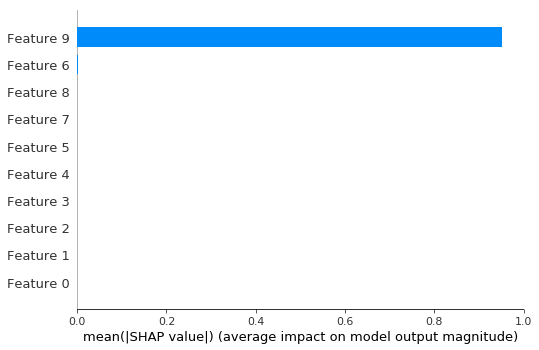

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.76785107e-04  0.00000000e+00
   0.00000000e+00  7.24222648e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.76785107e-04  0.00000000e+00
   0.00000000e+00  7.24222648e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.76785107e-04  0.00000000e+00
   0.00000000e+00  7.24222648e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.76785107e-04  0.00000000e+00
   0.00000000e+00  7.24222648e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.49553298e-03  0.00000000e+00
   0.00000000e+00 -1.09099468e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.49553298e-03  0.00000000e+00
   0.00000000e+00 -1.09099468e+00

   0.00000000e+00  7.24222648e-01]]
G
[[ 0.52414242  0.52414242 -0.39056673 ...  0.48336824  0.61624952
   0.61624952]
 [ 0.52414242  0.52414242 -0.39056673 ...  0.48336824 -1.19624907
  -1.19624907]
 [ 0.52414242  0.52414242 -0.39056673 ...  0.48336824  0.61624952
   0.61624952]
 ...
 [-1.57242726 -1.57242726 -0.39056673 ...  0.48336824  0.61624952
   0.61624952]
 [ 0.52414242 -1.57242726  2.21321149 ... -1.45010473  0.61624952
   0.61624952]
 [-1.57242726 -1.57242726 -0.39056673 ...  0.48336824  0.61624952
   0.61624952]]


In [30]:
samples_n = 100
loci_m = 10
beta_g = 1
e_noise = 0
unfinished = True
while unfinished:
        G, loci = simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise)
        shap_values, x_train, x_test, y_train, y_test, y_predict, forReg = shap_RFR_tree_train(G, 'all')
        max_holder = max_mean_feature(shap_values)
        if max_holder[0] == loci:
            unfinished = False

print("Length G")
print(len(G))
print("Length G[0]")
print(len(G[0]))
print("Causal Loci")
print(loci)
print("SHAP selected causal loci")
print(max_holder[0])
#print(shap_values)
#print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2)) 
#print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
#print("Root Mean squared error =", sqrt(round(metrics.mean_squared_error(y_test, y_predict), 2)))
#print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
#print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
#print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))
shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")
print(shap_values)
print('G')
print(G)

Y predict
[ 0.66310876  0.66310876 -1.1437271   0.66310876  0.66310876  0.66310876
  0.66310876  0.66310876 -1.1437271   0.66310876 -1.1437271   0.66310876
  0.66310876  0.66310876  0.66310876  0.66310876  0.66310876  0.66310876
  0.66310876  0.66310876  0.66310876  0.66310876  0.66310876  0.66310876
  0.66310876  0.66310876 -1.1437271   0.66310876  0.66310876  0.66310876
 -2.95056297  0.66310876  0.66310876  0.66310876  0.66310876  0.66310876
 -2.95056297 -1.1437271  -1.1437271   0.66310876 -2.95056297 -1.1437271
  0.66310876  0.66310876 -1.1437271   0.66310876  0.66310876  0.66310876
  0.66310876  0.66310876  0.66310876 -1.1437271  -1.1437271   0.66310876
  0.66310876  0.66310876  0.66310876 -1.1437271   0.66310876  0.66310876
  0.66310876  0.66310876  0.66310876  0.66310876 -1.1437271  -1.1437271
 -1.1437271  -1.1437271   0.66310876  0.66310876 -1.1437271   0.66310876
  0.66310876  0.66310876  0.66310876 -1.1437271  -1.1437271   0.66310876
  0.66310876  0.66310876  0.66310876 -1.143

  0.66310876 -1.1437271   0.66310876 -1.1437271 ]
Y predict
[ 0.18482603  0.18482603  0.18482603  1.6287794   0.18482603  0.18482603
  0.18482603  0.18482603  0.18482603  0.18482603 -1.25912734  0.18482603
  0.18482603  1.6287794   0.18482603  0.18482603  0.18482603 -1.25912734
  0.18482603  1.6287794  -1.25912734  1.6287794  -1.25912734  0.18482603
 -1.25912734  1.6287794   1.6287794  -1.25912734 -1.25912734  0.18482603
 -1.25912734  0.18482603  0.18482603  0.18482603  0.18482603  0.18482603
  0.18482603  0.18482603  0.18482603  1.6287794   0.18482603  0.18482603
  1.6287794   1.6287794   0.18482603 -1.25912734 -1.25912734  0.18482603
  0.18482603  1.6287794  -1.25912734 -1.25912734  0.18482603  1.6287794
 -1.25912734 -1.25912734  0.18482603 -1.25912734 -1.25912734  0.18482603
  0.18482603  0.18482603  0.18482603  0.18482603  1.6287794   0.18482603
  0.18482603  0.18482603  0.18482603  0.18482603 -1.25912734 -1.25912734
  0.18482603  1.6287794  -1.25912734  0.18482603 -1.25912734  0.1

  1.6287794   0.18482603  0.18482603  0.18482603]
Y predict
[ 0.70645138 -2.8169969   0.70645138 -1.05527276  0.70645138  0.70645138
 -1.05527276  0.70645138  0.70645138 -1.05527276  0.70645138  0.70645138
 -1.05527276  0.70645138  0.70645138 -1.05527276  0.70645138 -1.05527276
  0.70645138 -1.05527276 -1.05527276 -1.05527276 -1.05527276 -1.05527276
  0.70645138  0.70645138  0.70645138  0.70645138  0.70645138 -1.05527276
  0.70645138  0.70645138  0.70645138  0.70645138 -1.05527276  0.70645138
  0.70645138  0.70645138  0.70645138 -1.05527276  0.70645138  0.70645138
 -1.05527276  0.70645138  0.70645138  0.70645138  0.70645138 -1.05527276
  0.70645138  0.70645138  0.70645138  0.70645138  0.70645138  0.70645138
  0.70645138  0.70645138 -2.8169969  -1.05527276 -2.8169969   0.70645138
  0.70645138 -2.8169969  -1.05527276 -1.05527276  0.70645138  0.70645138
  0.70645138 -1.05527276  0.70645138  0.70645138 -1.05527276  0.70645138
  0.70645138 -1.05527276  0.70645138  0.70645138  0.70645138 -1.

  0.70645138 -1.05527276  0.70645138  0.70645138]
Y predict
[-0.38298357  1.06223744  1.06223744  1.06223744 -0.38298357  1.06223744
 -0.38298357  1.06223744  1.06223744 -0.38298357 -0.38298357  1.06223744
 -0.38298357 -1.82820458 -0.38298357 -0.38298357 -1.82820458 -0.38298357
  1.06223744  1.06223744 -0.38298357  1.06223744  1.06223744 -0.38298357
 -1.82820458  1.06223744  1.06223744 -0.38298357 -0.38298357 -0.38298357
  1.06223744 -1.82820458  1.06223744 -0.38298357  1.06223744  1.06223744
 -0.38298357 -0.38298357 -0.38298357  1.06223744  1.06223744 -1.82820458
  1.06223744  1.06223744 -1.82820458  1.06223744  1.06223744  1.06223744
  1.06223744 -1.82820458  1.06223744  1.06223744  1.06223744  1.06223744
 -0.38298357  1.06223744  1.06223744 -0.38298357 -0.38298357  1.06223744
 -0.38298357  1.06223744 -1.82820458 -1.82820458 -0.38298357 -0.38298357
  1.06223744  1.06223744 -0.38298357  1.06223744 -1.82820458 -0.38298357
 -1.82820458 -0.38298357 -0.38298357  1.06223744 -0.38298357 -1.

  1.06223744 -0.38298357  1.06223744  1.06223744]
Y predict
[-1.39190584  0.01976337  0.01976337 -1.39190584  0.01976337  0.01976337
  1.43143257 -1.39190584 -1.39190584 -1.39190584  1.43143257  0.01976337
  0.01976337 -1.39190584  1.43143257  1.43143257  0.01976337 -1.39190584
  0.01976337  0.01976337  0.01976337  0.01976337  1.43143257  1.43143257
  0.01976337 -1.39190584  1.43143257  0.01976337  0.01976337 -1.39190584
  0.01976337  0.01976337 -1.39190584  0.01976337  0.01976337  1.43143257
  1.43143257 -1.39190584  1.43143257 -1.39190584  0.01976337  0.01976337
  0.01976337 -1.39190584  0.01976337  0.01976337  0.01976337  0.01976337
  0.01976337  1.43143257  0.01976337  0.01976337 -1.39190584  0.01976337
 -1.39190584  1.43143257  0.01976337  0.01976337  0.01976337  1.43143257
  0.01976337 -1.39190584  0.01976337  0.01976337 -1.39190584 -1.39190584
  0.01976337  1.43143257 -1.39190584 -1.39190584  1.43143257  1.43143257
 -1.39190584  1.43143257  0.01976337  0.01976337  0.01976337  0.

  0.01976337  0.01976337  1.43143257  0.01976337]
Y predict
[ 0.87851753  0.87851753 -0.78534143 -0.78534143 -0.78534143 -0.78534143
  0.87851753  0.87851753  0.87851753  0.87851753 -0.78534143 -0.78534143
  0.87851753  0.87851753  0.87851753  0.87851753 -0.78534143 -0.78534143
  0.87851753  0.87851753 -0.78534143  0.87851753 -0.78534143  0.87851753
 -2.44920039  0.87851753 -0.78534143  0.87851753  0.87851753 -0.78534143
  0.87851753  0.87851753 -0.78534143 -0.78534143  0.87851753  0.87851753
 -0.78534143  0.87851753 -0.78534143 -0.78534143 -0.78534143 -0.78534143
  0.87851753  0.87851753  0.87851753 -0.78534143 -0.78534143  0.87851753
 -2.44920039  0.87851753 -0.78534143  0.87851753  0.87851753  0.87851753
  0.87851753 -0.78534143 -0.78534143  0.87851753 -0.78534143  0.87851753
  0.87851753 -0.78534143 -0.78534143 -0.78534143 -0.78534143  0.87851753
 -0.78534143 -0.78534143 -2.44920039  0.87851753  0.87851753  0.87851753
  0.87851753  0.87851753 -0.78534143  0.87851753  0.87851753  0.

 -0.78534143  0.87851753  0.87851753 -0.78534143]
Y predict
[ 1.91861378  0.4126375  -1.09333878  1.91861378  0.4126375   0.4126375
 -1.09333878  0.4126375  -1.09333878  1.91861378  0.4126375   0.4126375
  0.4126375  -1.09333878  0.4126375  -1.09333878  0.4126375  -1.09333878
  0.4126375  -1.09333878  0.4126375  -1.09333878  0.4126375   0.4126375
  0.4126375  -1.09333878  0.4126375   0.4126375   0.4126375  -1.09333878
  0.4126375  -1.09333878 -1.09333878 -1.09333878  0.4126375  -1.09333878
  0.4126375  -1.09333878 -1.09333878 -1.09333878 -1.09333878 -1.09333878
 -1.09333878  0.4126375  -1.09333878  0.4126375   0.4126375   1.91861378
  0.4126375   0.4126375  -1.09333878 -1.09333878  0.4126375  -1.09333878
  1.91861378 -1.09333878  0.4126375  -1.09333878 -1.09333878 -1.09333878
 -1.09333878  0.4126375  -1.09333878  1.91861378  0.4126375   0.4126375
  0.4126375   0.4126375  -1.09333878 -1.09333878  0.4126375   0.4126375
 -1.09333878 -1.09333878 -1.09333878  1.91861378 -1.09333878  1.91861

  0.4126375   0.4126375   0.4126375   0.4126375 ]
Y predict
[ 1.21261093 -1.64395193  1.21261093 -1.64395193 -1.64395193  1.21261093
  1.21261093 -1.64395193  1.21261093 -0.2156705  -0.2156705  -1.64395193
 -0.2156705  -0.2156705  -0.2156705  -0.2156705  -0.2156705   1.21261093
  1.21261093 -0.2156705   1.21261093  1.21261093 -0.2156705  -0.2156705
 -0.2156705  -1.64395193 -1.64395193  1.21261093 -0.2156705  -0.2156705
  1.21261093 -0.2156705   1.21261093  1.21261093 -1.64395193 -0.2156705
  1.21261093 -0.2156705  -0.2156705  -1.64395193 -0.2156705  -1.64395193
  1.21261093 -1.64395193 -0.2156705   1.21261093 -0.2156705   1.21261093
 -0.2156705   1.21261093 -0.2156705  -0.2156705  -0.2156705   1.21261093
 -0.2156705   1.21261093  1.21261093  1.21261093 -1.64395193 -0.2156705
 -0.2156705  -0.2156705   1.21261093 -0.2156705  -0.2156705  -0.2156705
 -0.2156705   1.21261093 -0.2156705   1.21261093 -0.2156705   1.21261093
  1.21261093 -0.2156705   1.21261093 -0.2156705  -0.2156705  -0.21567

 -0.2156705   1.21261093  1.21261093 -0.2156705 ]
Y predict
[ 0.27267865  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865 -3.46264527
  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865 -3.46264527  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865  0.27267865  0.27267865 -3.46264527  0.27267865
  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865  0.27267865
  0.27267865  0.27267865  0.27267865 -3.46264527  0.27267865  0.

  0.27267865  0.27267865  0.27267865  0.27267865]
Y predict
[-0.81744715 -0.81744715 -0.81744715  0.87850129  0.87850129  0.87850129
  0.87850129 -0.81744715  0.87850129 -0.81744715  0.87850129 -0.81744715
  0.87850129 -0.81744715 -0.81744715 -0.81744715 -0.81744715 -0.81744715
 -0.81744715 -0.81744715 -0.81744715 -0.81744715 -0.81744715  0.87850129
  0.87850129 -0.81744715 -0.81744715  0.87850129 -0.81744715 -0.81744715
 -0.81744715  0.87850129 -0.81744715 -0.81744715  0.87850129 -0.81744715
 -0.81744715  0.87850129 -0.81744715 -0.81744715  0.87850129  0.87850129
  0.87850129  0.87850129 -0.81744715 -0.81744715 -0.81744715 -0.81744715
 -0.81744715 -0.81744715 -0.81744715 -0.81744715 -0.81744715  2.57444973
  0.87850129 -0.81744715 -0.81744715  2.57444973  0.87850129  0.87850129
  0.87850129 -0.81744715 -0.81744715  0.87850129  0.87850129 -0.81744715
 -0.81744715 -0.81744715 -0.81744715  2.57444973 -0.81744715  0.87850129
 -0.81744715 -0.81744715 -0.81744715 -0.81744715  0.87850129 -0.

 -0.81744715 -0.81744715  2.57444973  0.87850129]
Y predict
[ 0.16461868  0.16461868  1.58374525  0.16461868  1.58374525  1.58374525
  0.16461868  0.16461868  0.16461868  1.58374525  0.16461868 -1.25450789
  0.16461868  0.16461868  1.58374525 -1.25450789 -1.25450789  0.16461868
  1.58374525  0.16461868  1.58374525  0.16461868  0.16461868  1.58374525
  0.16461868  0.16461868  0.16461868  0.16461868 -1.25450789 -1.25450789
  0.16461868  1.58374525 -1.25450789 -1.25450789  0.16461868  0.16461868
  0.16461868  0.16461868  0.16461868  0.16461868 -1.25450789  0.16461868
  1.58374525  0.16461868  0.16461868  0.16461868  0.16461868  1.58374525
  0.16461868  0.16461868 -1.25450789  0.16461868  0.16461868  0.16461868
 -1.25450789  1.58374525  0.16461868 -1.25450789  1.58374525  0.16461868
  1.58374525  0.16461868 -1.25450789  1.58374525  0.16461868  0.16461868
  0.16461868  1.58374525 -1.25450789  1.58374525 -1.25450789  0.16461868
  1.58374525  0.16461868  0.16461868  0.16461868 -1.25450789  0.

 -1.25450789  0.16461868 -1.25450789  0.16461868]
Y predict
[ 1.46793109  0.06723349  1.46793109  0.06723349  0.06723349  1.46793109
  0.06723349  0.06723349  1.46793109  1.46793109  0.06723349  0.06723349
  0.06723349  0.06723349  0.06723349  0.06723349  0.06723349  0.06723349
  0.06723349 -1.33346412  0.06723349  0.06723349  0.06723349 -1.33346412
 -1.33346412  1.46793109  0.06723349  0.06723349  1.46793109  0.06723349
  0.06723349  0.06723349 -1.33346412 -1.33346412  0.06723349 -1.33346412
  0.06723349 -1.33346412 -1.33346412  0.06723349 -1.33346412  1.46793109
  0.06723349  0.06723349  1.46793109  1.46793109  1.46793109  1.46793109
 -1.33346412  0.06723349 -1.33346412  0.06723349  0.06723349  0.06723349
  1.46793109  1.46793109  0.06723349  1.46793109 -1.33346412 -1.33346412
  1.46793109  0.06723349  0.06723349  1.46793109  0.06723349 -1.33346412
 -1.33346412  1.46793109  0.06723349  0.06723349  0.06723349 -1.33346412
  0.06723349  0.06723349  1.46793109  1.46793109  0.06723349  1.

  1.46793109  1.46793109  1.46793109 -1.33346412]
Y predict
[ 0.5796144  -1.45412033  0.5796144   0.5796144   0.5796144   0.5796144
  0.5796144   0.5796144   0.5796144  -1.45412033 -1.45412033  0.5796144
  0.5796144   0.5796144  -1.45412033 -1.45412033 -1.45412033  0.5796144
  0.5796144   0.5796144   0.5796144  -1.45412033  0.5796144   0.5796144
  0.5796144  -1.45412033 -1.45412033  0.5796144   0.5796144  -1.45412033
  0.5796144   0.5796144   0.5796144  -3.48785505  0.5796144   0.5796144
  0.5796144   0.5796144  -1.45412033  0.5796144   0.5796144  -1.45412033
  0.5796144   0.5796144  -1.45412033  0.5796144   0.5796144  -1.45412033
  0.5796144  -1.45412033  0.5796144  -1.45412033  0.5796144   0.5796144
  0.5796144   0.5796144  -1.45412033 -1.45412033 -1.45412033  0.5796144
 -1.45412033 -1.45412033  0.5796144   0.5796144   0.5796144   0.5796144
  0.5796144   0.5796144   0.5796144   0.5796144   0.5796144   0.5796144
  0.5796144   0.5796144   0.5796144   0.5796144   0.5796144   0.5796144
 

  0.5796144   0.5796144   0.5796144   0.5796144 ]
Y predict
[-0.66249778 -0.66249778 -0.66249778  0.87462005  0.87462005 -0.66249778
 -0.66249778  0.87462005  0.87462005  0.87462005 -0.66249778 -2.19961561
 -0.66249778  0.87462005 -0.66249778 -0.66249778 -0.66249778  0.87462005
  0.87462005  0.87462005 -2.19961561  0.87462005  0.87462005 -0.66249778
  0.87462005 -0.66249778  0.87462005  0.87462005  0.87462005  0.87462005
  0.87462005  0.87462005  0.87462005 -0.66249778  0.87462005  0.87462005
 -0.66249778  0.87462005  0.87462005 -2.19961561 -0.66249778 -0.66249778
  0.87462005 -0.66249778  0.87462005 -2.19961561 -0.66249778  0.87462005
  0.87462005  0.87462005 -0.66249778 -2.19961561 -0.66249778  0.87462005
  0.87462005 -2.19961561  0.87462005  0.87462005  0.87462005  0.87462005
 -0.66249778 -0.66249778  0.87462005 -0.66249778  0.87462005  0.87462005
  0.87462005  0.87462005 -0.66249778 -0.66249778 -2.19961561  0.87462005
  0.87462005  0.87462005  0.87462005 -2.19961561 -0.66249778 -0.

  0.87462005 -0.66249778  0.87462005  0.87462005]
Y predict
[-0.72362051  0.89160385  0.89160385 -0.72362051  0.89160385 -2.33884488
 -0.72362051  0.89160385 -0.72362051 -0.72362051 -0.72362051 -0.72362051
  0.89160385  0.89160385  0.89160385  0.89160385 -0.72362051 -0.72362051
 -0.72362051 -2.33884488  0.89160385  0.89160385  0.89160385  0.89160385
 -0.72362051 -0.72362051 -0.72362051  0.89160385  0.89160385  0.89160385
  0.89160385  0.89160385  0.89160385 -0.72362051 -0.72362051  0.89160385
  0.89160385  0.89160385 -0.72362051 -0.72362051  0.89160385 -2.33884488
 -0.72362051  0.89160385 -0.72362051  0.89160385 -0.72362051  0.89160385
 -0.72362051  0.89160385 -0.72362051  0.89160385 -0.72362051  0.89160385
 -0.72362051 -0.72362051 -0.72362051  0.89160385 -0.72362051  0.89160385
 -0.72362051 -0.72362051  0.89160385 -0.72362051  0.89160385 -0.72362051
  0.89160385  0.89160385  0.89160385 -0.72362051  0.89160385  0.89160385
 -2.33884488  0.89160385 -0.72362051  0.89160385  0.89160385  0.

 -0.72362051  0.89160385 -0.72362051 -0.72362051]
Y predict
[ 1.0638825 -0.7485238 -0.7485238 -0.7485238 -0.7485238 -0.7485238
  1.0638825 -0.7485238  1.0638825 -0.7485238  1.0638825 -0.7485238
 -0.7485238  1.0638825  1.0638825 -0.7485238  1.0638825  1.0638825
  1.0638825  1.0638825  1.0638825  2.8762888  1.0638825 -0.7485238
 -0.7485238 -0.7485238 -0.7485238  1.0638825 -0.7485238  1.0638825
 -0.7485238 -0.7485238 -0.7485238  1.0638825 -0.7485238 -0.7485238
 -0.7485238 -0.7485238 -0.7485238  2.8762888 -0.7485238 -0.7485238
 -0.7485238 -0.7485238 -0.7485238 -0.7485238 -0.7485238 -0.7485238
 -0.7485238  1.0638825 -0.7485238  1.0638825  1.0638825 -0.7485238
  2.8762888 -0.7485238  1.0638825  1.0638825  1.0638825 -0.7485238
  1.0638825  1.0638825 -0.7485238 -0.7485238 -0.7485238  1.0638825
 -0.7485238  1.0638825  1.0638825 -0.7485238  1.0638825 -0.7485238
 -0.7485238 -0.7485238  1.0638825  1.0638825 -0.7485238  1.0638825
  1.0638825 -0.7485238 -0.7485238  1.0638825 -0.7485238  1.0638825
 -

 -0.7485238 -0.7485238  1.0638825 -0.7485238]
Y predict
[ 0.73832068 -1.0195857   0.73832068 -1.0195857  -1.0195857  -2.77749209
  0.73832068  0.73832068  0.73832068 -1.0195857   0.73832068  0.73832068
  0.73832068  0.73832068  0.73832068  0.73832068 -1.0195857   0.73832068
  0.73832068 -1.0195857  -1.0195857  -1.0195857   0.73832068  0.73832068
  0.73832068 -1.0195857  -1.0195857  -1.0195857  -1.0195857  -1.0195857
 -1.0195857   0.73832068  0.73832068  0.73832068 -2.77749209 -1.0195857
 -1.0195857   0.73832068  0.73832068  0.73832068  0.73832068  0.73832068
 -1.0195857   0.73832068 -1.0195857  -1.0195857   0.73832068  0.73832068
  0.73832068  0.73832068  0.73832068 -1.0195857  -1.0195857   0.73832068
  0.73832068  0.73832068  0.73832068 -1.0195857   0.73832068 -2.77749209
  0.73832068  0.73832068  0.73832068 -1.0195857   0.73832068 -1.0195857
 -1.0195857   0.73832068  0.73832068  0.73832068 -1.0195857   0.73832068
 -1.0195857   0.73832068  0.73832068 -1.0195857  -1.0195857   0.7383206

  0.73832068 -1.0195857  -2.77749209  0.73832068]
Y predict
[-0.67921692 -0.67921692 -0.67921692 -0.67921692  1.11291216 -0.67921692
  2.90504125 -0.67921692  1.11291216  1.11291216  1.11291216  1.11291216
 -0.67921692  1.11291216 -0.67921692 -0.67921692  1.11291216 -0.67921692
  1.11291216  2.90504125  1.11291216 -0.67921692 -0.67921692 -0.67921692
 -0.67921692  1.11291216 -0.67921692 -0.67921692 -0.67921692 -0.67921692
 -0.67921692 -0.67921692  1.11291216 -0.67921692  1.11291216 -0.67921692
 -0.67921692  1.11291216  1.11291216 -0.67921692 -0.67921692  1.11291216
  1.11291216  1.11291216  1.11291216  1.11291216 -0.67921692  1.11291216
 -0.67921692 -0.67921692 -0.67921692 -0.67921692  2.90504125  1.11291216
  1.11291216 -0.67921692  1.11291216 -0.67921692 -0.67921692 -0.67921692
 -0.67921692  1.11291216  1.11291216 -0.67921692 -0.67921692 -0.67921692
  1.11291216 -0.67921692 -0.67921692 -0.67921692  2.90504125  1.11291216
 -0.67921692 -0.67921692 -0.67921692 -0.67921692 -0.67921692 -0.

  1.11291216  2.90504125  1.11291216 -0.67921692]
Y predict
[ 0.02906191 -1.42403357 -1.42403357  1.48215739  0.02906191  1.48215739
  0.02906191  1.48215739 -1.42403357  0.02906191  1.48215739  0.02906191
  0.02906191  1.48215739  0.02906191  0.02906191  0.02906191  1.48215739
 -1.42403357  1.48215739 -1.42403357  0.02906191  0.02906191  1.48215739
  0.02906191  1.48215739  0.02906191 -1.42403357 -1.42403357 -1.42403357
  0.02906191 -1.42403357  1.48215739  0.02906191  0.02906191 -1.42403357
  0.02906191 -1.42403357 -1.42403357  0.02906191  0.02906191  0.02906191
  1.48215739 -1.42403357 -1.42403357 -1.42403357  0.02906191  0.02906191
  0.02906191  0.02906191 -1.42403357  0.02906191  1.48215739  0.02906191
  0.02906191  0.02906191  1.48215739  0.02906191  0.02906191  0.02906191
 -1.42403357  0.02906191  0.02906191  0.02906191  0.02906191  0.02906191
  0.02906191  0.02906191  0.02906191 -1.42403357  1.48215739 -1.42403357
  0.02906191 -1.42403357  1.48215739  0.02906191  1.48215739  1.

  0.02906191  0.02906191  1.48215739  1.48215739]
Y predict
[-0.36812387 -0.36812387 -0.36812387  2.42069331 -0.36812387  2.42069331
 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387
 -0.36812387  2.42069331 -0.36812387 -0.36812387 -0.36812387 -0.36812387
 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387
 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387
  2.42069331 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387
 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387
 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387
 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387
 -0.36812387 -0.36812387  2.42069331 -0.36812387 -0.36812387 -0.36812387
 -0.36812387 -0.36812387 -0.36812387 -0.36812387  2.42069331 -0.36812387
 -0.36812387 -0.36812387 -0.36812387 -0.36812387  2.42069331 -0.36812387
 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.36812387 -0.

 -0.36812387 -0.36812387 -0.36812387 -0.36812387]
Y predict
[-0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699  5.1747249  -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699  5.1747249  -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.

 -0.19324699 -0.19324699 -0.19324699 -0.19324699]
Y predict
[ 0.3932226   0.3932226   0.3932226  -2.31865739  0.3932226   0.3932226
  0.3932226   0.3932226   0.3932226   0.3932226   0.3932226   0.3932226
  0.3932226   0.3932226   0.3932226  -2.31865739  0.3932226   0.3932226
  0.3932226   0.3932226   0.3932226   0.3932226  -2.31865739  0.3932226
  0.3932226   0.3932226   0.3932226   0.3932226   0.3932226  -2.31865739
 -2.31865739  0.3932226   0.3932226   0.3932226   0.3932226   0.3932226
  0.3932226  -2.31865739  0.3932226   0.3932226  -4.92206218  0.3932226
  0.3932226   0.3932226   0.3932226   0.3932226   0.3932226   0.3932226
  0.3932226   0.3932226   0.3932226   0.3932226   0.3932226   0.3932226
 -2.31865739  0.3932226   0.3932226   0.3932226   0.3932226   0.3932226
 -2.31865739  0.3932226   0.3932226   0.3932226   0.3932226   0.3932226
  0.3932226   0.3932226   0.3932226   0.3932226   0.3932226  -2.31865739
  0.3932226   0.3932226   0.3932226   0.3932226   0.3932226   0.3932226
  

  0.3932226   0.3932226   0.3932226   0.3932226 ]
Y predict
[ 1.29185487 -0.15155839  1.29185487  1.29185487 -0.15155839 -0.15155839
 -1.59497165  1.29185487 -0.15155839 -1.59497165 -0.15155839 -0.15155839
 -0.15155839 -1.59497165 -0.15155839 -0.15155839  1.29185487 -0.15155839
 -1.59497165  1.29185487 -1.59497165 -0.15155839 -0.15155839 -0.15155839
  1.29185487 -0.15155839 -0.15155839 -0.15155839 -0.15155839 -0.15155839
  1.29185487  1.29185487 -1.59497165  1.29185487 -0.15155839 -1.59497165
 -1.59497165 -0.15155839 -0.15155839 -0.15155839 -0.15155839  1.29185487
  1.29185487 -1.59497165  1.29185487 -0.15155839 -1.59497165 -0.15155839
 -0.15155839 -0.15155839  1.29185487 -0.15155839 -0.15155839 -0.15155839
 -1.59497165  1.29185487  1.29185487  1.29185487  1.29185487 -1.59497165
 -0.15155839 -1.59497165 -0.15155839 -0.15155839 -0.15155839 -0.15155839
 -0.15155839 -0.15155839  1.29185487  1.29185487 -0.15155839 -0.15155839
  1.29185487  1.29185487  1.29185487  1.29185487 -0.15155839 -0.

 -0.15155839 -0.15155839 -0.15155839 -1.59497165]
Y predict
[-0.57475436 -0.57475436 -0.57475436 -0.57475436 -0.57475436 -0.57475436
 -0.57475436 -0.57475436 -0.57475436  1.50017113  1.50017113  1.50017113
 -0.57475436 -0.57475436  1.50017113  1.50017113 -0.57475436  1.50017113
 -0.57475436 -0.57475436  1.50017113  1.50017113 -0.57475436 -0.57475436
  3.57509661 -0.57475436  1.50017113  1.50017113  1.50017113  1.50017113
 -0.57475436 -0.57475436  1.50017113 -0.57475436 -0.57475436 -0.57475436
 -0.57475436 -0.57475436 -0.57475436 -0.57475436  1.50017113 -0.57475436
 -0.57475436  1.50017113 -0.57475436 -0.57475436 -0.57475436 -0.57475436
 -0.57475436 -0.57475436 -0.57475436 -0.57475436 -0.57475436 -0.57475436
  1.50017113 -0.57475436 -0.57475436 -0.57475436 -0.57475436 -0.57475436
 -0.57475436 -0.57475436 -0.57475436 -0.57475436 -0.57475436 -0.57475436
  1.50017113  1.50017113 -0.57475436 -0.57475436  1.50017113 -0.57475436
  1.50017113  1.50017113 -0.57475436 -0.57475436  1.50017113 -0.

 -0.57475436 -0.57475436  1.50017113 -0.57475436]
Y predict
[ 1.70508109  0.27703998  0.27703998  1.70508109 -1.15100114 -1.15100114
  1.70508109  0.27703998  0.27703998  0.27703998  0.27703998  0.27703998
 -1.15100114 -1.15100114  1.70508109  0.27703998 -1.15100114 -1.15100114
  1.70508109  1.70508109 -1.15100114 -1.15100114  0.27703998  1.70508109
  0.27703998  0.27703998  1.70508109  1.70508109  1.70508109 -1.15100114
 -1.15100114  1.70508109  0.27703998  0.27703998 -1.15100114  0.27703998
  0.27703998 -1.15100114 -1.15100114  0.27703998 -1.15100114  1.70508109
  0.27703998 -1.15100114  1.70508109 -1.15100114  0.27703998 -1.15100114
 -1.15100114  1.70508109 -1.15100114 -1.15100114 -1.15100114  0.27703998
  0.27703998 -1.15100114  0.27703998 -1.15100114  0.27703998  1.70508109
 -1.15100114  0.27703998 -1.15100114  0.27703998 -1.15100114  0.27703998
  0.27703998  0.27703998 -1.15100114  0.27703998  0.27703998  0.27703998
 -1.15100114  0.27703998 -1.15100114 -1.15100114 -1.15100114  1.

 -1.15100114  0.27703998  0.27703998 -1.15100114]
Y predict
[ 0.99131347 -0.49047049  0.99131347  0.99131347  0.99131347 -0.49047049
 -1.97225446  0.99131347 -0.49047049 -0.49047049  0.99131347  0.99131347
 -0.49047049  0.99131347 -1.97225446  0.99131347 -0.49047049 -0.49047049
 -0.49047049 -0.49047049  0.99131347 -0.49047049  0.99131347  0.99131347
 -0.49047049 -0.49047049  0.99131347 -0.49047049 -0.49047049  0.99131347
 -1.97225446  0.99131347  0.99131347  0.99131347  0.99131347 -0.49047049
 -1.97225446 -0.49047049  0.99131347  0.99131347 -0.49047049  0.99131347
  0.99131347  0.99131347  0.99131347  0.99131347  0.99131347  0.99131347
 -0.49047049 -1.97225446 -0.49047049 -0.49047049  0.99131347  0.99131347
 -1.97225446  0.99131347 -0.49047049 -0.49047049  0.99131347 -0.49047049
  0.99131347 -0.49047049 -0.49047049 -0.49047049 -0.49047049 -0.49047049
  0.99131347 -0.49047049 -1.97225446 -0.49047049 -0.49047049  0.99131347
  0.99131347  0.99131347 -0.49047049 -0.49047049  0.99131347  0.

 -0.49047049  0.99131347 -0.49047049  0.99131347]
Y predict
[-0.79931089  0.81872735 -0.79931089 -0.79931089  0.81872735  0.81872735
  0.81872735  0.81872735 -0.79931089 -0.79931089  0.81872735  0.81872735
  0.81872735  0.81872735  0.81872735  0.81872735  0.81872735 -0.79931089
 -0.79931089 -0.79931089  0.81872735 -0.79931089  0.81872735  0.81872735
 -0.79931089  0.81872735 -0.79931089  0.81872735  0.81872735  0.81872735
 -0.79931089  0.81872735  0.81872735 -2.41734914 -0.79931089 -0.79931089
  0.81872735  0.81872735 -0.79931089 -0.79931089  0.81872735 -0.79931089
  0.81872735 -0.79931089 -0.79931089  0.81872735  0.81872735  0.81872735
  0.81872735 -0.79931089 -0.79931089  0.81872735 -0.79931089 -0.79931089
 -0.79931089  0.81872735 -0.79931089 -0.79931089 -0.79931089 -0.79931089
 -0.79931089  0.81872735  0.81872735 -0.79931089  0.81872735 -0.79931089
  0.81872735  0.81872735  0.81872735 -0.79931089  0.81872735  0.81872735
  0.81872735  0.81872735  0.81872735  0.81872735 -0.79931089  0.

 -0.79931089 -0.79931089  0.81872735  0.81872735]
Y predict
[-0.38357172 -0.38357172  2.47890381  2.47890381 -0.38357172 -0.38357172
 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172
  2.47890381 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172
 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172
  2.47890381 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172
 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172  2.47890381
 -0.38357172 -0.38357172 -0.38357172  2.47890381 -0.38357172 -0.38357172
 -0.38357172 -0.38357172 -0.38357172 -0.38357172  2.47890381 -0.38357172
 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172  2.47890381
 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172 -0.38357172
 -0.38357172 -0.38357172  2.47890381 -0.38357172 -0.38357172 -0.38357172
  2.47890381 -0.38357172 -0.38357172  2.47890381 -0.38357172 -0.38357172
 -0.38357172 -0.38357172 -0.38357172 -0.38357172  2.47890381 -0.

 -0.38357172 -0.38357172 -0.38357172 -0.38357172]
Y predict
[-0.44789953  1.80285186 -0.44789953 -0.44789953 -0.44789953  1.80285186
 -0.44789953 -0.44789953  1.80285186 -0.44789953  1.80285186 -0.44789953
 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953  4.05360324
 -0.44789953 -0.44789953  1.80285186 -0.44789953 -0.44789953 -0.44789953
  1.80285186 -0.44789953 -0.44789953 -0.44789953  1.80285186 -0.44789953
 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953
 -0.44789953  1.80285186 -0.44789953  1.80285186  1.80285186 -0.44789953
 -0.44789953 -0.44789953 -0.44789953 -0.44789953  1.80285186 -0.44789953
  1.80285186 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953
 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953
 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953
 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953
 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.44789953 -0.

 -0.44789953 -0.44789953 -0.44789953 -0.44789953]
Y predict
[ 0.87816528 -0.70126868  0.87816528  0.87816528  0.87816528 -2.28070264
  0.87816528 -2.28070264  0.87816528  0.87816528 -0.70126868 -0.70126868
 -0.70126868  0.87816528  0.87816528 -0.70126868 -0.70126868  0.87816528
  0.87816528  0.87816528 -0.70126868 -0.70126868  0.87816528 -0.70126868
  0.87816528 -0.70126868 -0.70126868  0.87816528  0.87816528  0.87816528
  0.87816528  0.87816528 -0.70126868  0.87816528  0.87816528 -2.28070264
  0.87816528 -2.28070264  0.87816528  0.87816528  0.87816528  0.87816528
 -0.70126868 -0.70126868  0.87816528 -0.70126868  0.87816528 -0.70126868
 -0.70126868  0.87816528  0.87816528  0.87816528 -0.70126868  0.87816528
 -0.70126868  0.87816528  0.87816528 -0.70126868  0.87816528 -0.70126868
 -2.28070264 -0.70126868  0.87816528 -0.70126868 -2.28070264  0.87816528
  0.87816528  0.87816528 -0.70126868 -2.28070264  0.87816528 -0.70126868
 -2.28070264  0.87816528 -0.70126868  0.87816528 -0.70126868  0.

  0.87816528 -0.70126868  0.87816528 -0.70126868]
Y predict
[ 0.72468962  0.72468962  0.72468962 -1.06909656  0.72468962  0.72468962
 -1.06909656  0.72468962  0.72468962  0.72468962  0.72468962  0.72468962
  0.72468962  0.72468962 -1.06909656 -1.06909656 -2.86288274 -1.06909656
  0.72468962  0.72468962  0.72468962 -1.06909656 -1.06909656  0.72468962
 -1.06909656  0.72468962  0.72468962  0.72468962  0.72468962  0.72468962
 -1.06909656  0.72468962  0.72468962  0.72468962  0.72468962  0.72468962
  0.72468962  0.72468962 -1.06909656 -1.06909656 -1.06909656  0.72468962
  0.72468962  0.72468962  0.72468962  0.72468962 -1.06909656  0.72468962
 -2.86288274 -1.06909656  0.72468962 -1.06909656 -1.06909656  0.72468962
 -1.06909656 -1.06909656  0.72468962 -2.86288274  0.72468962 -2.86288274
 -1.06909656  0.72468962  0.72468962  0.72468962 -1.06909656 -2.86288274
 -1.06909656 -1.06909656  0.72468962  0.72468962 -1.06909656  0.72468962
  0.72468962  0.72468962  0.72468962  0.72468962  0.72468962 -1.

  0.72468962  0.72468962  0.72468962  0.72468962]
Y predict
[ 1.18490788  1.18490788 -0.1770552   1.18490788  1.18490788  1.18490788
 -0.1770552   1.18490788  1.18490788 -0.1770552  -0.1770552  -0.1770552
  1.18490788 -0.1770552  -0.1770552  -0.1770552  -1.53901828  1.18490788
  1.18490788 -1.53901828 -1.53901828 -0.1770552   1.18490788 -0.1770552
 -0.1770552  -1.53901828  1.18490788  1.18490788  1.18490788  1.18490788
 -1.53901828  1.18490788 -1.53901828 -0.1770552  -0.1770552  -0.1770552
 -0.1770552   1.18490788  1.18490788 -0.1770552   1.18490788 -1.53901828
 -0.1770552   1.18490788 -1.53901828  1.18490788  1.18490788 -0.1770552
 -1.53901828 -1.53901828  1.18490788  1.18490788 -1.53901828 -1.53901828
 -0.1770552  -1.53901828  1.18490788 -0.1770552  -0.1770552  -0.1770552
 -0.1770552  -1.53901828  1.18490788 -0.1770552  -1.53901828 -0.1770552
 -0.1770552  -0.1770552   1.18490788 -0.1770552   1.18490788 -0.1770552
 -0.1770552  -0.1770552   1.18490788  1.18490788  1.18490788 -0.1770552

  1.18490788 -1.53901828 -0.1770552   1.18490788]
Y predict
[-1.2352635  -1.2352635   0.17004196  0.17004196  0.17004196 -1.2352635
 -1.2352635  -1.2352635   1.57534742 -1.2352635   1.57534742  0.17004196
  0.17004196  1.57534742  1.57534742  0.17004196 -1.2352635  -1.2352635
 -1.2352635  -1.2352635  -1.2352635  -1.2352635   0.17004196  0.17004196
  0.17004196 -1.2352635   0.17004196  0.17004196  0.17004196  0.17004196
 -1.2352635   0.17004196 -1.2352635   0.17004196  1.57534742 -1.2352635
  0.17004196 -1.2352635  -1.2352635  -1.2352635   0.17004196  0.17004196
  1.57534742 -1.2352635   1.57534742  0.17004196  1.57534742 -1.2352635
 -1.2352635   1.57534742 -1.2352635   1.57534742  1.57534742 -1.2352635
 -1.2352635   0.17004196  0.17004196  1.57534742 -1.2352635   1.57534742
  0.17004196  1.57534742  0.17004196  1.57534742 -1.2352635   0.17004196
  1.57534742  0.17004196 -1.2352635  -1.2352635   0.17004196  0.17004196
  0.17004196  0.17004196  1.57534742  0.17004196  0.17004196 -1.23526

 -1.2352635  -1.2352635   0.17004196  0.17004196]
Y predict
[ 0.00983139 -1.39465329 -1.39465329  0.00983139  0.00983139 -1.39465329
  0.00983139 -1.39465329  1.41431608  1.41431608 -1.39465329  0.00983139
 -1.39465329  0.00983139  1.41431608  0.00983139  1.41431608  1.41431608
 -1.39465329  0.00983139 -1.39465329 -1.39465329  0.00983139  1.41431608
  0.00983139  1.41431608  0.00983139  1.41431608 -1.39465329  0.00983139
  0.00983139  0.00983139  1.41431608  1.41431608  0.00983139 -1.39465329
 -1.39465329 -1.39465329  1.41431608  0.00983139  0.00983139  1.41431608
 -1.39465329  1.41431608  0.00983139 -1.39465329  0.00983139 -1.39465329
  1.41431608  1.41431608  0.00983139  0.00983139 -1.39465329  0.00983139
  0.00983139  0.00983139  0.00983139  0.00983139 -1.39465329 -1.39465329
  0.00983139  0.00983139 -1.39465329  0.00983139 -1.39465329 -1.39465329
  0.00983139  0.00983139 -1.39465329 -1.39465329 -1.39465329 -1.39465329
  0.00983139  0.00983139  0.00983139  0.00983139 -1.39465329  1.

  0.00983139 -1.39465329  1.41431608  0.00983139]
Y predict
[-1.16941069 -1.16941069  1.75411604  0.29235267 -1.16941069 -1.16941069
  0.29235267  0.29235267  0.29235267  1.75411604  0.29235267  0.29235267
  1.75411604 -1.16941069 -1.16941069  1.75411604 -1.16941069  1.75411604
  0.29235267 -1.16941069  0.29235267  0.29235267  0.29235267  1.75411604
  0.29235267  0.29235267 -1.16941069 -1.16941069 -1.16941069 -1.16941069
 -1.16941069  1.75411604 -1.16941069  0.29235267  1.75411604  0.29235267
  0.29235267 -1.16941069  0.29235267 -1.16941069  0.29235267 -1.16941069
 -1.16941069 -1.16941069 -1.16941069  1.75411604  0.29235267 -1.16941069
  1.75411604 -1.16941069 -1.16941069  0.29235267  0.29235267  0.29235267
  1.75411604 -1.16941069  0.29235267 -1.16941069  0.29235267 -1.16941069
  0.29235267  0.29235267 -1.16941069 -1.16941069  0.29235267  0.29235267
 -1.16941069  1.75411604  1.75411604 -1.16941069  0.29235267 -1.16941069
  1.75411604  1.75411604 -1.16941069  0.29235267  0.29235267  0.

  0.29235267  0.29235267 -1.16941069  0.29235267]
Y predict
[-0.47228762 -1.96215393  1.01757869 -0.47228762 -0.47228762 -0.47228762
 -0.47228762 -0.47228762 -0.47228762  1.01757869  1.01757869 -1.96215393
  1.01757869  1.01757869  1.01757869 -0.47228762 -0.47228762 -0.47228762
 -0.47228762 -0.47228762  1.01757869 -0.47228762 -0.47228762 -0.47228762
  1.01757869  1.01757869  1.01757869  1.01757869  1.01757869  1.01757869
 -0.47228762 -1.96215393 -0.47228762 -0.47228762 -0.47228762 -0.47228762
 -0.47228762 -0.47228762 -0.47228762 -0.47228762  1.01757869  1.01757869
 -0.47228762  1.01757869  1.01757869  1.01757869 -0.47228762 -0.47228762
  1.01757869 -0.47228762 -0.47228762 -0.47228762  1.01757869 -1.96215393
  1.01757869 -0.47228762  1.01757869 -0.47228762 -0.47228762  1.01757869
  1.01757869 -0.47228762 -0.47228762 -0.47228762 -0.47228762 -0.47228762
 -1.96215393  1.01757869 -0.47228762 -1.96215393  1.01757869 -0.47228762
  1.01757869  1.01757869  1.01757869 -0.47228762 -0.47228762 -0.

 -0.47228762  1.01757869  1.01757869 -0.47228762]
Y predict
[ 0.16008958 -1.25663238 -1.25663238  0.16008958  0.16008958 -1.25663238
  0.16008958  0.16008958  1.57681155  1.57681155  1.57681155  0.16008958
  0.16008958  0.16008958 -1.25663238 -1.25663238  0.16008958  1.57681155
  1.57681155 -1.25663238  0.16008958  1.57681155  0.16008958  1.57681155
  0.16008958 -1.25663238  0.16008958  0.16008958  0.16008958  0.16008958
  0.16008958  0.16008958  1.57681155  0.16008958  0.16008958  1.57681155
  0.16008958  0.16008958 -1.25663238  0.16008958 -1.25663238 -1.25663238
  0.16008958 -1.25663238  0.16008958 -1.25663238  0.16008958 -1.25663238
  1.57681155  0.16008958 -1.25663238  1.57681155  0.16008958  0.16008958
  0.16008958  0.16008958  1.57681155  0.16008958 -1.25663238  0.16008958
  1.57681155  0.16008958  1.57681155 -1.25663238  0.16008958  0.16008958
  0.16008958  0.16008958 -1.25663238  1.57681155  0.16008958 -1.25663238
  0.16008958 -1.25663238  1.57681155 -1.25663238  0.16008958  0.

  0.16008958 -1.25663238  0.16008958 -1.25663238]
Y predict
[ 0.6322078   0.6322078   0.6322078  -1.27203256 -1.27203256  0.6322078
 -1.27203256  0.6322078  -1.27203256  0.6322078   0.6322078   0.6322078
 -3.17627292 -1.27203256  0.6322078   0.6322078   0.6322078  -1.27203256
  0.6322078  -1.27203256  0.6322078  -1.27203256  0.6322078   0.6322078
 -1.27203256 -3.17627292 -1.27203256 -1.27203256  0.6322078  -1.27203256
  0.6322078   0.6322078  -1.27203256  0.6322078   0.6322078   0.6322078
  0.6322078   0.6322078   0.6322078  -3.17627292  0.6322078  -1.27203256
 -1.27203256  0.6322078  -1.27203256 -1.27203256 -1.27203256  0.6322078
  0.6322078   0.6322078  -1.27203256  0.6322078   0.6322078   0.6322078
  0.6322078   0.6322078  -1.27203256 -1.27203256 -1.27203256  0.6322078
  0.6322078   0.6322078   0.6322078  -1.27203256 -1.27203256  0.6322078
 -1.27203256  0.6322078  -1.27203256  0.6322078   0.6322078  -1.27203256
 -1.27203256  0.6322078  -1.27203256  0.6322078  -1.27203256  0.6322078


  0.6322078   0.6322078   0.6322078  -1.27203256]
Y predict
[ 0.54338553 -1.56275994 -1.56275994 -1.56275994  0.54338553  0.54338553
  0.54338553  0.54338553 -1.56275994  0.54338553 -3.66890541  0.54338553
  0.54338553  0.54338553  0.54338553  0.54338553 -1.56275994  0.54338553
 -1.56275994  0.54338553  0.54338553  0.54338553  0.54338553  0.54338553
 -1.56275994  0.54338553  0.54338553  0.54338553  0.54338553  0.54338553
 -1.56275994 -1.56275994  0.54338553  0.54338553  0.54338553  0.54338553
  0.54338553  0.54338553  0.54338553 -1.56275994  0.54338553  0.54338553
  0.54338553  0.54338553  0.54338553  0.54338553 -1.56275994 -1.56275994
  0.54338553  0.54338553  0.54338553  0.54338553  0.54338553  0.54338553
  0.54338553  0.54338553  0.54338553  0.54338553  0.54338553 -1.56275994
 -1.56275994  0.54338553 -1.56275994 -1.56275994  0.54338553  0.54338553
 -1.56275994  0.54338553  0.54338553 -1.56275994  0.54338553  0.54338553
  0.54338553 -1.56275994  0.54338553 -1.56275994 -1.56275994 -1.

 -1.56275994 -1.56275994  0.54338553  0.54338553]
Y predict
[-1.23759669 -1.23759669  0.16876319  0.16876319  0.16876319  1.57512306
 -1.23759669 -1.23759669 -1.23759669 -1.23759669 -1.23759669  1.57512306
 -1.23759669  0.16876319 -1.23759669 -1.23759669 -1.23759669  1.57512306
  1.57512306  0.16876319 -1.23759669  0.16876319  1.57512306  0.16876319
  0.16876319  1.57512306  1.57512306 -1.23759669 -1.23759669 -1.23759669
 -1.23759669  0.16876319  0.16876319  1.57512306  0.16876319 -1.23759669
  1.57512306 -1.23759669  0.16876319 -1.23759669  0.16876319  0.16876319
 -1.23759669 -1.23759669  0.16876319  0.16876319  0.16876319  1.57512306
 -1.23759669  1.57512306  1.57512306 -1.23759669  1.57512306  0.16876319
 -1.23759669  1.57512306 -1.23759669  0.16876319  0.16876319 -1.23759669
 -1.23759669  0.16876319  0.16876319 -1.23759669  0.16876319  1.57512306
  0.16876319 -1.23759669 -1.23759669  0.16876319  0.16876319  1.57512306
  0.16876319  0.16876319  1.57512306  1.57512306 -1.23759669  0.

 -1.23759669  0.16876319 -1.23759669  0.16876319]
Y predict
[-0.93136252  0.70547847 -0.93136252 -0.93136252 -0.93136252 -0.93136252
 -0.93136252 -0.93136252 -0.93136252 -0.93136252  0.70547847 -0.93136252
 -0.93136252 -0.93136252  0.70547847  0.70547847  0.70547847 -0.93136252
 -0.93136252 -0.93136252  0.70547847 -0.93136252 -0.93136252  0.70547847
 -0.93136252  0.70547847  0.70547847 -0.93136252 -0.93136252  0.70547847
  0.70547847 -0.93136252 -0.93136252  2.34231945  0.70547847 -0.93136252
 -0.93136252 -0.93136252  0.70547847  0.70547847  0.70547847 -0.93136252
  0.70547847  0.70547847 -0.93136252 -0.93136252  0.70547847 -0.93136252
  0.70547847  0.70547847 -0.93136252  2.34231945 -0.93136252  0.70547847
 -0.93136252 -0.93136252  0.70547847 -0.93136252 -0.93136252 -0.93136252
  0.70547847  0.70547847  0.70547847  0.70547847  0.70547847  2.34231945
  0.70547847  0.70547847 -0.93136252 -0.93136252  0.70547847 -0.93136252
 -0.93136252  2.34231945  0.70547847  0.70547847  0.70547847  2.

  2.34231945 -0.93136252  0.70547847  0.70547847]
Y predict
[ 0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982  -3.99363901  0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982   0.2503982   0.2503982
  0.2503982   0.2503982   0.2503982   0.2503982  -3.99363901  0.2503982
  0.2503982   0.2503982   0.2503982  -3.99363901  0.2503982   0.2503982
  0.

  0.2503982   0.2503982   0.2503982   0.2503982 ]
Y predict
[ 0.77996403  0.77996403 -0.86552971 -0.86552971  0.77996403  0.77996403
  0.77996403 -0.86552971 -0.86552971  0.77996403 -0.86552971 -0.86552971
 -0.86552971  0.77996403  0.77996403 -2.51102345  0.77996403 -0.86552971
  0.77996403 -0.86552971 -2.51102345 -0.86552971  0.77996403 -0.86552971
  0.77996403 -0.86552971  0.77996403  0.77996403 -0.86552971  0.77996403
 -0.86552971 -0.86552971 -0.86552971  0.77996403  0.77996403  0.77996403
 -0.86552971 -0.86552971 -0.86552971  0.77996403  0.77996403  0.77996403
 -2.51102345  0.77996403 -0.86552971  0.77996403 -2.51102345  0.77996403
  0.77996403 -2.51102345 -0.86552971  0.77996403  0.77996403  0.77996403
  0.77996403 -0.86552971  0.77996403  0.77996403 -0.86552971 -0.86552971
 -0.86552971  0.77996403 -0.86552971 -0.86552971  0.77996403 -2.51102345
 -2.51102345  0.77996403  0.77996403 -0.86552971  0.77996403  0.77996403
  0.77996403 -0.86552971  0.77996403 -2.51102345  0.77996403  0.

 -2.51102345 -2.51102345  0.77996403  0.77996403]
Y predict
[-1.07636996  0.6910684  -1.07636996  0.6910684   0.6910684   0.6910684
  0.6910684   0.6910684   0.6910684   0.6910684   0.6910684  -1.07636996
  0.6910684  -2.84380831  0.6910684   0.6910684  -1.07636996  0.6910684
  0.6910684   0.6910684   0.6910684   0.6910684   0.6910684   0.6910684
 -1.07636996 -1.07636996  0.6910684   0.6910684   0.6910684   0.6910684
  0.6910684   0.6910684   0.6910684  -1.07636996 -1.07636996  0.6910684
 -1.07636996  0.6910684   0.6910684   0.6910684   0.6910684   0.6910684
 -1.07636996  0.6910684   0.6910684   0.6910684  -1.07636996  0.6910684
 -1.07636996  0.6910684  -1.07636996  0.6910684   0.6910684   0.6910684
  0.6910684  -2.84380831  0.6910684   0.6910684   0.6910684   0.6910684
  0.6910684   0.6910684   0.6910684  -1.07636996  0.6910684  -1.07636996
  0.6910684   0.6910684  -1.07636996  0.6910684   0.6910684   0.6910684
  0.6910684   0.6910684   0.6910684   0.6910684  -1.07636996  0.6910684
  

  0.6910684   0.6910684   0.6910684  -1.07636996]
Y predict
[ 0.96439804 -0.5424739   0.96439804 -2.04934583 -0.5424739  -2.04934583
 -0.5424739  -0.5424739  -0.5424739   0.96439804 -0.5424739   0.96439804
 -0.5424739   0.96439804  0.96439804  0.96439804 -0.5424739   0.96439804
 -0.5424739   0.96439804  0.96439804 -0.5424739  -2.04934583 -0.5424739
 -0.5424739   0.96439804 -0.5424739  -2.04934583 -0.5424739  -0.5424739
 -2.04934583 -0.5424739  -0.5424739  -0.5424739  -0.5424739   0.96439804
  0.96439804  0.96439804 -0.5424739  -0.5424739  -2.04934583 -0.5424739
  0.96439804  0.96439804  0.96439804 -0.5424739  -0.5424739   0.96439804
  0.96439804 -0.5424739   0.96439804  0.96439804 -0.5424739   0.96439804
  0.96439804  0.96439804  0.96439804 -2.04934583  0.96439804  0.96439804
 -0.5424739  -0.5424739   0.96439804 -0.5424739  -0.5424739  -0.5424739
  0.96439804  0.96439804  0.96439804 -0.5424739   0.96439804 -0.5424739
  0.96439804  0.96439804 -0.5424739  -0.5424739  -0.5424739  -0.54247

 -0.5424739  -0.5424739  -0.5424739   0.96439804]
Y predict
[-1.92577238  1.03467709  1.03467709 -0.44554765 -1.92577238 -0.44554765
 -1.92577238  1.03467709 -0.44554765  1.03467709 -0.44554765  1.03467709
  1.03467709 -0.44554765 -0.44554765 -1.92577238  1.03467709 -0.44554765
 -0.44554765 -1.92577238 -0.44554765 -1.92577238  1.03467709  1.03467709
  1.03467709  1.03467709 -1.92577238 -1.92577238 -0.44554765 -0.44554765
  1.03467709 -0.44554765 -1.92577238  1.03467709  1.03467709 -0.44554765
 -0.44554765  1.03467709  1.03467709 -1.92577238  1.03467709  1.03467709
  1.03467709  1.03467709 -1.92577238 -0.44554765  1.03467709  1.03467709
  1.03467709  1.03467709 -0.44554765 -0.44554765 -0.44554765 -0.44554765
  1.03467709 -0.44554765 -1.92577238  1.03467709  1.03467709 -0.44554765
 -1.92577238  1.03467709 -0.44554765 -0.44554765 -0.44554765  1.03467709
  1.03467709  1.03467709 -1.92577238 -0.44554765 -0.44554765  1.03467709
 -1.92577238  1.03467709 -1.92577238  1.03467709  1.03467709  1.

 -0.44554765 -0.44554765 -0.44554765  1.03467709]
Y predict
[-0.55547449 -0.55547449 -0.55547449 -2.0773224  -2.0773224  -0.55547449
 -0.55547449 -2.0773224  -0.55547449  0.96637343 -0.55547449 -0.55547449
  0.96637343 -2.0773224  -0.55547449 -0.55547449 -0.55547449  0.96637343
  0.96637343  0.96637343  0.96637343 -0.55547449 -0.55547449 -2.0773224
  0.96637343  0.96637343 -0.55547449  0.96637343  0.96637343  0.96637343
 -0.55547449 -0.55547449  0.96637343 -0.55547449 -2.0773224  -0.55547449
 -0.55547449 -0.55547449 -0.55547449  0.96637343 -0.55547449  0.96637343
  0.96637343 -0.55547449 -2.0773224  -0.55547449  0.96637343 -0.55547449
  0.96637343 -0.55547449  0.96637343 -2.0773224  -0.55547449 -0.55547449
  0.96637343 -2.0773224  -2.0773224   0.96637343  0.96637343  0.96637343
  0.96637343  0.96637343 -0.55547449  0.96637343  0.96637343  0.96637343
  0.96637343 -0.55547449  0.96637343 -0.55547449  0.96637343  0.96637343
 -2.0773224  -0.55547449  0.96637343 -0.55547449 -0.55547449 -0.5

  0.96637343 -0.55547449 -0.55547449 -0.55547449]
Y predict
[ 0.12340351  0.12340351  0.12340351  0.12340351  0.12340351 -8.10349719
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351
  0.12340351  0.12340351  0.12340351  0.12340351  0.12340351  0.

  0.12340351  0.12340351  0.12340351  0.12340351]
Y predict
[ 0.958041   -0.57974552 -0.57974552 -0.57974552 -0.57974552  0.958041
  0.958041   -0.57974552 -0.57974552 -0.57974552  0.958041    0.958041
 -0.57974552  0.958041   -2.11753203  0.958041    0.958041    0.958041
 -0.57974552 -0.57974552  0.958041    0.958041   -0.57974552 -0.57974552
  0.958041   -2.11753203  0.958041   -0.57974552 -0.57974552  0.958041
  0.958041   -0.57974552 -0.57974552 -0.57974552  0.958041   -0.57974552
  0.958041   -0.57974552 -2.11753203  0.958041   -2.11753203  0.958041
  0.958041   -0.57974552  0.958041   -0.57974552  0.958041    0.958041
  0.958041   -0.57974552  0.958041    0.958041   -0.57974552 -0.57974552
  0.958041    0.958041    0.958041    0.958041   -0.57974552  0.958041
  0.958041   -0.57974552  0.958041   -0.57974552  0.958041    0.958041
 -0.57974552 -0.57974552  0.958041    0.958041   -0.57974552  0.958041
 -0.57974552 -2.11753203 -0.57974552  0.958041   -2.11753203  0.958041
  0.958041 

 -0.57974552 -0.57974552  0.958041   -0.57974552]
Y predict
[ 0.27032005  0.27032005 -1.13030199 -1.13030199  0.27032005  1.6709421
  1.6709421   0.27032005  1.6709421   0.27032005 -1.13030199  0.27032005
  0.27032005 -1.13030199 -1.13030199  1.6709421   0.27032005  0.27032005
 -1.13030199 -1.13030199  1.6709421   0.27032005 -1.13030199  0.27032005
  0.27032005  1.6709421  -1.13030199  0.27032005 -1.13030199  0.27032005
  0.27032005  0.27032005  0.27032005  0.27032005  0.27032005 -1.13030199
 -1.13030199  1.6709421   0.27032005 -1.13030199  0.27032005 -1.13030199
  0.27032005  0.27032005  1.6709421  -1.13030199 -1.13030199 -1.13030199
  0.27032005 -1.13030199  0.27032005  0.27032005  0.27032005 -1.13030199
  0.27032005 -1.13030199  0.27032005  0.27032005 -1.13030199 -1.13030199
  0.27032005  0.27032005  1.6709421   0.27032005 -1.13030199  1.6709421
 -1.13030199 -1.13030199  0.27032005 -1.13030199  0.27032005  1.6709421
  0.27032005  0.27032005  0.27032005  0.27032005 -1.13030199 -1.130

  0.27032005  1.6709421  -1.13030199  0.27032005]
Y predict
[-0.24966316  1.1851826  -0.24966316  1.1851826  -0.24966316 -0.24966316
  1.1851826  -0.24966316 -0.24966316  1.1851826   1.1851826  -0.24966316
 -0.24966316 -0.24966316  1.1851826  -0.24966316 -0.24966316 -0.24966316
 -1.68450892  1.1851826  -1.68450892 -0.24966316 -0.24966316 -1.68450892
 -0.24966316 -0.24966316 -0.24966316 -0.24966316  1.1851826   1.1851826
 -0.24966316  1.1851826   1.1851826  -1.68450892 -0.24966316 -0.24966316
 -1.68450892 -0.24966316 -0.24966316 -0.24966316 -0.24966316 -0.24966316
 -0.24966316  1.1851826   1.1851826   1.1851826   1.1851826  -0.24966316
 -0.24966316  1.1851826  -0.24966316 -0.24966316 -1.68450892 -0.24966316
 -0.24966316 -0.24966316  1.1851826  -1.68450892 -0.24966316 -0.24966316
 -0.24966316 -0.24966316  1.1851826   1.1851826  -1.68450892  1.1851826
  1.1851826   1.1851826   1.1851826   1.1851826   1.1851826  -0.24966316
 -0.24966316 -1.68450892 -1.68450892 -1.68450892 -0.24966316  1.18

 -0.24966316 -1.68450892  1.1851826   1.1851826 ]
Y predict
[-0.08126497 -0.08126497 -1.53242523  1.36989529  1.36989529 -0.08126497
 -0.08126497 -1.53242523 -0.08126497 -0.08126497 -1.53242523 -1.53242523
 -1.53242523 -0.08126497 -0.08126497 -0.08126497 -0.08126497 -0.08126497
  1.36989529  1.36989529 -0.08126497 -1.53242523 -0.08126497 -0.08126497
 -0.08126497 -0.08126497 -0.08126497 -0.08126497 -1.53242523 -0.08126497
 -1.53242523  1.36989529  1.36989529 -1.53242523 -0.08126497 -0.08126497
 -0.08126497  1.36989529 -1.53242523  1.36989529 -0.08126497 -0.08126497
  1.36989529 -0.08126497 -0.08126497 -0.08126497 -1.53242523 -0.08126497
  1.36989529 -0.08126497 -0.08126497 -1.53242523  1.36989529 -1.53242523
 -0.08126497 -0.08126497 -1.53242523 -0.08126497 -1.53242523 -1.53242523
 -0.08126497 -0.08126497  1.36989529 -0.08126497 -0.08126497 -0.08126497
 -1.53242523 -0.08126497 -0.08126497 -0.08126497  1.36989529 -0.08126497
  1.36989529  1.36989529 -0.08126497 -1.53242523 -1.53242523 -0.

  1.36989529 -0.08126497 -0.08126497 -0.08126497]
Y predict
[ 1.05643796  1.05643796  1.05643796 -0.41903405  1.05643796  1.05643796
 -1.89450606  1.05643796 -0.41903405  1.05643796 -1.89450606 -0.41903405
 -1.89450606  1.05643796 -0.41903405 -0.41903405  1.05643796  1.05643796
 -0.41903405 -0.41903405  1.05643796 -0.41903405 -0.41903405 -1.89450606
 -0.41903405  1.05643796 -0.41903405 -0.41903405 -0.41903405 -0.41903405
  1.05643796 -0.41903405 -0.41903405 -0.41903405  1.05643796 -1.89450606
 -0.41903405  1.05643796 -0.41903405  1.05643796 -1.89450606  1.05643796
  1.05643796 -0.41903405 -0.41903405 -1.89450606 -0.41903405 -0.41903405
 -0.41903405 -0.41903405  1.05643796 -0.41903405 -1.89450606 -0.41903405
 -1.89450606 -0.41903405  1.05643796  1.05643796  1.05643796 -0.41903405
 -0.41903405  1.05643796 -0.41903405 -0.41903405 -0.41903405 -0.41903405
 -0.41903405 -0.41903405 -0.41903405  1.05643796 -1.89450606 -0.41903405
 -0.41903405 -1.89450606 -0.41903405 -0.41903405 -1.89450606 -0.

  1.05643796  1.05643796 -0.41903405 -0.41903405]
Y predict
[ 0.67834837  0.67834837  0.67834837 -1.12098417  0.67834837  0.67834837
  0.67834837 -1.12098417 -1.12098417  0.67834837  0.67834837  0.67834837
 -1.12098417  0.67834837 -2.92031671  0.67834837 -1.12098417  0.67834837
  0.67834837 -1.12098417  0.67834837  0.67834837  0.67834837  0.67834837
  0.67834837  0.67834837  0.67834837 -1.12098417  0.67834837  0.67834837
 -1.12098417 -1.12098417 -1.12098417  0.67834837  0.67834837 -1.12098417
  0.67834837  0.67834837 -2.92031671  0.67834837  0.67834837 -1.12098417
 -2.92031671  0.67834837  0.67834837 -1.12098417  0.67834837  0.67834837
  0.67834837  0.67834837 -1.12098417  0.67834837  0.67834837  0.67834837
  0.67834837  0.67834837  0.67834837  0.67834837  0.67834837  0.67834837
 -1.12098417  0.67834837  0.67834837 -1.12098417 -1.12098417  0.67834837
  0.67834837 -1.12098417 -1.12098417  0.67834837  0.67834837  0.67834837
  0.67834837 -1.12098417  0.67834837 -1.12098417  0.67834837  0.

  0.67834837  0.67834837  0.67834837 -1.12098417]
Y predict
[-0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 12.9374168  -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615
 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.04476615 -0.

 -0.04476615 -0.04476615 -0.04476615 -0.04476615]
Y predict
[ 1.01683813  1.01683813 -0.45258113 -0.45258113  1.01683813 -1.9220004
 -0.45258113 -1.9220004  -0.45258113  1.01683813 -0.45258113 -0.45258113
  1.01683813  1.01683813 -0.45258113  1.01683813 -1.9220004  -0.45258113
  1.01683813 -1.9220004  -0.45258113  1.01683813 -0.45258113 -0.45258113
 -0.45258113 -0.45258113  1.01683813  1.01683813  1.01683813 -0.45258113
 -1.9220004   1.01683813 -1.9220004   1.01683813  1.01683813 -0.45258113
 -1.9220004   1.01683813 -0.45258113  1.01683813 -0.45258113  1.01683813
  1.01683813  1.01683813 -0.45258113 -0.45258113  1.01683813 -0.45258113
  1.01683813 -0.45258113 -0.45258113 -0.45258113  1.01683813 -0.45258113
  1.01683813 -0.45258113 -1.9220004   1.01683813 -0.45258113  1.01683813
 -0.45258113 -0.45258113  1.01683813  1.01683813  1.01683813 -0.45258113
 -0.45258113  1.01683813  1.01683813 -0.45258113  1.01683813 -0.45258113
 -0.45258113 -0.45258113  1.01683813 -0.45258113 -0.45258113 -0.4

  1.01683813 -0.45258113 -1.9220004   1.01683813]
Y predict
[ 0.53750643 -1.02048322  0.53750643  0.53750643  0.53750643  2.09549608
  0.53750643 -1.02048322  2.09549608  0.53750643 -1.02048322 -1.02048322
 -1.02048322 -1.02048322 -1.02048322  0.53750643  0.53750643  2.09549608
 -1.02048322  0.53750643  0.53750643  0.53750643  0.53750643 -1.02048322
 -1.02048322 -1.02048322  0.53750643 -1.02048322  0.53750643 -1.02048322
  0.53750643  0.53750643  0.53750643  2.09549608  0.53750643 -1.02048322
  0.53750643  0.53750643  0.53750643 -1.02048322 -1.02048322  0.53750643
  0.53750643  0.53750643 -1.02048322 -1.02048322 -1.02048322  0.53750643
 -1.02048322 -1.02048322  0.53750643 -1.02048322 -1.02048322  0.53750643
 -1.02048322 -1.02048322  0.53750643 -1.02048322 -1.02048322  2.09549608
 -1.02048322 -1.02048322 -1.02048322  0.53750643  0.53750643 -1.02048322
  0.53750643  0.53750643  0.53750643 -1.02048322  0.53750643  0.53750643
 -1.02048322  0.53750643 -1.02048322  2.09549608 -1.02048322  2.

  2.09549608 -1.02048322  0.53750643  0.53750643]
Y predict
[ 0.41369374  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374
  0.41369374  0.41369374  0.41369374 -2.18815366 -2.18815366  0.41369374
  0.41369374  0.41369374  0.41369374 -2.18815366 -2.18815366  0.41369374
  0.41369374  0.41369374 -2.18815366  0.41369374  0.41369374  0.41369374
 -2.18815366  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374
  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374
  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374
  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374
  0.41369374  0.41369374 -2.18815366  0.41369374  0.41369374  0.41369374
  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374
 -2.18815366  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374
 -2.18815366 -2.18815366  0.41369374  0.41369374  0.41369374 -2.18815366
  0.41369374  0.41369374  0.41369374  0.41369374  0.41369374  0.

  0.41369374  0.41369374 -2.18815366  0.41369374]
Y predict
[-1.15735549  0.20906185 -1.15735549 -1.15735549  0.20906185 -1.15735549
 -1.15735549  1.57547919 -1.15735549  0.20906185  1.57547919 -1.15735549
  0.20906185  0.20906185 -1.15735549  1.57547919  0.20906185  0.20906185
  1.57547919  0.20906185 -1.15735549 -1.15735549  1.57547919 -1.15735549
  0.20906185  0.20906185  0.20906185  0.20906185  0.20906185 -1.15735549
  0.20906185  1.57547919  0.20906185  1.57547919 -1.15735549 -1.15735549
  0.20906185  0.20906185  0.20906185  0.20906185  1.57547919 -1.15735549
 -1.15735549  0.20906185  1.57547919 -1.15735549  1.57547919  0.20906185
 -1.15735549  1.57547919  0.20906185 -1.15735549  1.57547919 -1.15735549
  0.20906185  1.57547919 -1.15735549 -1.15735549  0.20906185  0.20906185
 -1.15735549 -1.15735549  0.20906185 -1.15735549  0.20906185  1.57547919
 -1.15735549  1.57547919 -1.15735549  0.20906185  1.57547919 -1.15735549
 -1.15735549  1.57547919  1.57547919  1.57547919  0.20906185  0.

  0.20906185 -1.15735549  0.20906185  0.20906185]
Y predict
[ 0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699 -5.1747249   0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699 -5.1747249   0.19324699
  0.19324699  0.19324699  0.19324699  0.19324699  0.19324699  0.

  0.19324699  0.19324699  0.19324699  0.19324699]
Y predict
[-0.31767504 -1.7616525  -0.31767504  1.12630242 -0.31767504  1.12630242
 -0.31767504  1.12630242 -0.31767504 -0.31767504 -1.7616525   1.12630242
 -0.31767504 -0.31767504  1.12630242  1.12630242  1.12630242 -0.31767504
  1.12630242 -0.31767504 -0.31767504  1.12630242  1.12630242  1.12630242
  1.12630242 -0.31767504 -0.31767504 -0.31767504  1.12630242 -0.31767504
 -0.31767504  1.12630242 -0.31767504 -1.7616525  -0.31767504  1.12630242
  1.12630242 -0.31767504 -0.31767504  1.12630242  1.12630242  1.12630242
  1.12630242  1.12630242 -0.31767504  1.12630242 -1.7616525  -1.7616525
  1.12630242  1.12630242 -0.31767504  1.12630242 -0.31767504  1.12630242
 -1.7616525  -1.7616525   1.12630242 -1.7616525   1.12630242 -1.7616525
 -0.31767504 -0.31767504 -1.7616525  -0.31767504  1.12630242  1.12630242
 -0.31767504  1.12630242 -0.31767504 -0.31767504 -0.31767504 -1.7616525
 -0.31767504 -0.31767504  1.12630242 -0.31767504 -1.7616525  -0.317

  1.12630242  1.12630242  1.12630242 -0.31767504]
Y predict
[-0.56962133  1.52457473 -0.56962133  1.52457473 -0.56962133 -0.56962133
 -0.56962133 -0.56962133  1.52457473 -0.56962133 -0.56962133 -0.56962133
 -0.56962133 -0.56962133 -0.56962133 -0.56962133 -0.56962133 -0.56962133
 -0.56962133  3.6187708  -0.56962133  1.52457473 -0.56962133 -0.56962133
 -0.56962133 -0.56962133 -0.56962133 -0.56962133 -0.56962133 -0.56962133
 -0.56962133 -0.56962133 -0.56962133 -0.56962133 -0.56962133 -0.56962133
  1.52457473 -0.56962133 -0.56962133 -0.56962133 -0.56962133 -0.56962133
  1.52457473 -0.56962133 -0.56962133 -0.56962133  1.52457473  3.6187708
 -0.56962133  1.52457473 -0.56962133 -0.56962133 -0.56962133  1.52457473
 -0.56962133  3.6187708  -0.56962133  3.6187708  -0.56962133 -0.56962133
 -0.56962133 -0.56962133 -0.56962133  1.52457473 -0.56962133 -0.56962133
 -0.56962133 -0.56962133 -0.56962133 -0.56962133  1.52457473 -0.56962133
 -0.56962133 -0.56962133 -0.56962133 -0.56962133  1.52457473  1.5

 -0.56962133 -0.56962133 -0.56962133 -0.56962133]
Y predict
[ 0.55077776  0.55077776  0.55077776  0.55077776 -1.51981533 -1.51981533
  0.55077776  0.55077776  0.55077776  0.55077776  0.55077776  0.55077776
  0.55077776  0.55077776  0.55077776  0.55077776  0.55077776 -1.51981533
  0.55077776  0.55077776  0.55077776 -1.51981533  0.55077776  0.55077776
 -1.51981533  0.55077776 -1.51981533 -1.51981533 -1.51981533 -1.51981533
  0.55077776  0.55077776 -1.51981533  0.55077776  0.55077776  0.55077776
  0.55077776  0.55077776  0.55077776 -1.51981533  0.55077776  0.55077776
  0.55077776 -1.51981533 -1.51981533  0.55077776  0.55077776  0.55077776
  0.55077776  0.55077776  0.55077776  0.55077776  0.55077776  0.55077776
  0.55077776 -1.51981533  0.55077776  0.55077776  0.55077776  0.55077776
 -1.51981533  0.55077776  0.55077776  0.55077776 -1.51981533  0.55077776
  0.55077776  0.55077776  0.55077776  0.55077776  0.55077776  0.55077776
  0.55077776 -3.59040841  0.55077776  0.55077776 -3.59040841  0.

 -1.51981533  0.55077776  0.55077776 -3.59040841]
Y predict
[ 0.97705515 -0.75838917 -0.75838917  0.97705515 -0.75838917  0.97705515
  0.97705515 -0.75838917 -0.75838917 -0.75838917 -0.75838917  2.71249947
 -0.75838917 -0.75838917  0.97705515 -0.75838917 -0.75838917 -0.75838917
  0.97705515 -0.75838917  0.97705515  0.97705515 -0.75838917 -0.75838917
 -0.75838917 -0.75838917 -0.75838917 -0.75838917 -0.75838917 -0.75838917
  0.97705515 -0.75838917 -0.75838917 -0.75838917 -0.75838917 -0.75838917
  0.97705515  2.71249947  0.97705515 -0.75838917 -0.75838917  0.97705515
  0.97705515 -0.75838917  0.97705515  2.71249947 -0.75838917 -0.75838917
 -0.75838917  2.71249947  0.97705515  0.97705515 -0.75838917 -0.75838917
  0.97705515 -0.75838917  0.97705515  0.97705515 -0.75838917 -0.75838917
 -0.75838917 -0.75838917  0.97705515  0.97705515 -0.75838917  0.97705515
  0.97705515 -0.75838917  0.97705515  0.97705515  0.97705515  0.97705515
 -0.75838917 -0.75838917  0.97705515 -0.75838917 -0.75838917 -0.

 -0.75838917 -0.75838917 -0.75838917  0.97705515]
Y predict
[-0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444  2.41924945
 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444
 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444
 -0.38730444  2.41924945 -0.38730444 -0.38730444 -0.38730444 -0.38730444
 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444
 -0.38730444 -0.38730444  2.41924945 -0.38730444 -0.38730444 -0.38730444
 -0.38730444  2.41924945 -0.38730444  2.41924945 -0.38730444 -0.38730444
 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444
 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444
 -0.38730444 -0.38730444  2.41924945 -0.38730444  2.41924945 -0.38730444
 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444  2.41924945
 -0.38730444 -0.38730444  2.41924945  2.41924945 -0.38730444 -0.38730444
 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.38730444 -0.

 -0.38730444  2.41924945 -0.38730444 -0.38730444]
Y predict
[-0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799
 -0.29524799  3.21960907 -0.29524799 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799  3.21960907 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799  3.21960907
 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799  3.21960907 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799 -0.29524799
 -0.29524799 -0.29524799 -0.29524799  3.21960907 -0.29524799 -0.

 -0.29524799 -0.29524799 -0.29524799 -0.29524799]
Y predict
[ 0.53787401 -0.9479658   0.53787401  0.53787401 -0.9479658   0.53787401
  0.53787401  2.02371383 -0.9479658   0.53787401 -0.9479658   0.53787401
 -0.9479658   0.53787401 -0.9479658  -0.9479658   0.53787401  0.53787401
 -0.9479658   0.53787401  0.53787401 -0.9479658   0.53787401 -0.9479658
  2.02371383 -0.9479658  -0.9479658   0.53787401 -0.9479658   0.53787401
 -0.9479658  -0.9479658  -0.9479658  -0.9479658   0.53787401  0.53787401
 -0.9479658   0.53787401  2.02371383 -0.9479658   0.53787401 -0.9479658
  0.53787401 -0.9479658   0.53787401  2.02371383  0.53787401 -0.9479658
  0.53787401  0.53787401  0.53787401  0.53787401 -0.9479658  -0.9479658
  2.02371383 -0.9479658   0.53787401 -0.9479658  -0.9479658   0.53787401
 -0.9479658  -0.9479658   2.02371383 -0.9479658   0.53787401 -0.9479658
  0.53787401  0.53787401  0.53787401  0.53787401  0.53787401  0.53787401
 -0.9479658  -0.9479658   0.53787401  0.53787401  0.53787401  0.53787

 -0.9479658   0.53787401 -0.9479658   0.53787401]
Y predict
[ 0.60775389 -0.95459545  0.60775389 -0.95459545 -0.95459545  0.60775389
  0.60775389  0.60775389  2.17010323 -0.95459545  0.60775389  0.60775389
 -0.95459545  2.17010323 -0.95459545 -0.95459545 -0.95459545 -0.95459545
  0.60775389  2.17010323  0.60775389 -0.95459545  0.60775389  2.17010323
  0.60775389 -0.95459545 -0.95459545 -0.95459545 -0.95459545 -0.95459545
  2.17010323  0.60775389  0.60775389  0.60775389 -0.95459545  0.60775389
  0.60775389 -0.95459545  0.60775389  0.60775389  0.60775389  0.60775389
  2.17010323  0.60775389 -0.95459545  2.17010323 -0.95459545  0.60775389
  2.17010323 -0.95459545  0.60775389 -0.95459545  0.60775389  0.60775389
  0.60775389  0.60775389  0.60775389 -0.95459545  0.60775389  0.60775389
 -0.95459545 -0.95459545  0.60775389  0.60775389  2.17010323  0.60775389
  2.17010323 -0.95459545 -0.95459545  2.17010323 -0.95459545 -0.95459545
  0.60775389 -0.95459545 -0.95459545 -0.95459545 -0.95459545  0.

  0.60775389  0.60775389 -0.95459545  0.60775389]
Y predict
[-1.16840224  0.6658242   0.6658242   0.6658242   0.6658242   0.6658242
 -1.16840224  0.6658242  -1.16840224  0.6658242   0.6658242   0.6658242
  0.6658242  -1.16840224  0.6658242  -1.16840224  0.6658242   0.6658242
  0.6658242  -1.16840224 -1.16840224  0.6658242   0.6658242  -1.16840224
 -1.16840224  0.6658242   0.6658242  -1.16840224 -1.16840224  0.6658242
  0.6658242   0.6658242   0.6658242   0.6658242  -1.16840224  0.6658242
  0.6658242   0.6658242   0.6658242   0.6658242   0.6658242  -1.16840224
 -1.16840224  0.6658242   0.6658242  -1.16840224  0.6658242   0.6658242
 -1.16840224  0.6658242  -1.16840224 -1.16840224  0.6658242  -1.16840224
  0.6658242   0.6658242   0.6658242   0.6658242  -1.16840224  0.6658242
  0.6658242   0.6658242  -1.16840224  0.6658242  -3.00262868  0.6658242
  0.6658242  -1.16840224  0.6658242  -1.16840224  0.6658242  -1.16840224
  0.6658242   0.6658242  -1.16840224 -1.16840224  0.6658242   0.6658242


  0.6658242   0.6658242  -1.16840224 -1.16840224]
Y predict
[ 0.80136071  0.80136071  0.80136071 -0.84752964  0.80136071 -0.84752964
  2.45025106  0.80136071  0.80136071 -0.84752964  0.80136071 -0.84752964
 -0.84752964  0.80136071 -0.84752964 -0.84752964 -0.84752964  0.80136071
  0.80136071  2.45025106 -0.84752964  0.80136071  0.80136071 -0.84752964
 -0.84752964  0.80136071 -0.84752964 -0.84752964  0.80136071 -0.84752964
  0.80136071 -0.84752964  0.80136071  2.45025106 -0.84752964 -0.84752964
 -0.84752964  0.80136071  0.80136071  2.45025106 -0.84752964  2.45025106
  0.80136071 -0.84752964 -0.84752964  0.80136071  0.80136071  2.45025106
  0.80136071  0.80136071  0.80136071  0.80136071  0.80136071  0.80136071
 -0.84752964 -0.84752964 -0.84752964 -0.84752964  2.45025106  0.80136071
 -0.84752964 -0.84752964 -0.84752964 -0.84752964  0.80136071 -0.84752964
 -0.84752964  0.80136071 -0.84752964 -0.84752964  0.80136071 -0.84752964
 -0.84752964  0.80136071 -0.84752964 -0.84752964 -0.84752964 -0.

  0.80136071 -0.84752964  0.80136071 -0.84752964]
Y predict
[-0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 16.03582791 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546  -0.0548546
 -0.

 -0.0548546  -0.0548546  -0.0548546  -0.0548546 ]
Y predict
[ 1.4409166   1.4409166  -0.58568903 -0.58568903 -0.58568903 -0.58568903
 -0.58568903 -0.58568903 -0.58568903 -0.58568903 -0.58568903 -0.58568903
 -0.58568903  1.4409166  -0.58568903 -0.58568903 -0.58568903 -0.58568903
 -0.58568903  1.4409166  -0.58568903 -0.58568903  1.4409166  -0.58568903
 -0.58568903 -0.58568903 -0.58568903 -0.58568903 -0.58568903 -0.58568903
  1.4409166  -0.58568903 -0.58568903 -0.58568903  1.4409166  -0.58568903
 -0.58568903 -0.58568903 -0.58568903  1.4409166  -0.58568903  1.4409166
  1.4409166  -0.58568903  1.4409166  -0.58568903 -0.58568903 -0.58568903
 -0.58568903  1.4409166  -0.58568903 -0.58568903  1.4409166   1.4409166
 -0.58568903 -0.58568903 -0.58568903  1.4409166  -0.58568903 -0.58568903
 -0.58568903 -0.58568903  1.4409166  -0.58568903 -0.58568903 -0.58568903
 -0.58568903 -0.58568903 -0.58568903 -0.58568903 -0.58568903  1.4409166
 -0.58568903 -0.58568903  1.4409166  -0.58568903 -0.58568903 -0.585

  1.4409166  -0.58568903  1.4409166  -0.58568903]
Y predict
[ 0.08567932  0.08567932  0.08567932  0.08567932  0.08567932  0.08567932
 -1.34230937  0.08567932 -1.34230937  0.08567932 -1.34230937 -1.34230937
  0.08567932  0.08567932  0.08567932  0.08567932  1.51366802  1.51366802
  1.51366802 -1.34230937 -1.34230937  1.51366802  0.08567932  1.51366802
  0.08567932 -1.34230937  0.08567932 -1.34230937  0.08567932 -1.34230937
  1.51366802  0.08567932  0.08567932  0.08567932  1.51366802  0.08567932
  0.08567932  0.08567932  0.08567932 -1.34230937 -1.34230937 -1.34230937
  0.08567932  0.08567932  1.51366802  1.51366802  0.08567932 -1.34230937
  1.51366802  0.08567932  0.08567932  1.51366802  0.08567932  1.51366802
  0.08567932 -1.34230937  0.08567932  0.08567932  1.51366802  0.08567932
  0.08567932  1.51366802 -1.34230937  0.08567932  1.51366802 -1.34230937
 -1.34230937  0.08567932 -1.34230937 -1.34230937  0.08567932  0.08567932
 -1.34230937  0.08567932  0.08567932  0.08567932  0.08567932  0.

 -1.34230937 -1.34230937  0.08567932 -1.34230937]
Y predict
[ 1.83653322 -1.09957105  1.83653322 -1.09957105  0.36848108  1.83653322
  0.36848108  0.36848108  0.36848108 -1.09957105  1.83653322 -1.09957105
  0.36848108  0.36848108 -1.09957105 -1.09957105 -1.09957105  0.36848108
  1.83653322 -1.09957105  0.36848108  0.36848108 -1.09957105  0.36848108
  1.83653322 -1.09957105 -1.09957105 -1.09957105  1.83653322 -1.09957105
  0.36848108  1.83653322 -1.09957105 -1.09957105 -1.09957105 -1.09957105
  0.36848108  0.36848108  0.36848108 -1.09957105 -1.09957105 -1.09957105
  0.36848108  0.36848108  0.36848108  0.36848108  1.83653322 -1.09957105
  0.36848108  0.36848108  0.36848108 -1.09957105 -1.09957105 -1.09957105
  0.36848108  0.36848108  0.36848108  1.83653322 -1.09957105  0.36848108
  0.36848108  1.83653322 -1.09957105  0.36848108 -1.09957105  0.36848108
 -1.09957105  0.36848108  0.36848108 -1.09957105  0.36848108  0.36848108
  1.83653322  0.36848108  0.36848108  0.36848108  0.36848108  0.

  0.36848108  1.83653322 -1.09957105 -1.09957105]
Y predict
[ 1.62316371 -0.54105457  1.62316371 -0.54105457  1.62316371 -0.54105457
 -0.54105457 -0.54105457 -0.54105457 -0.54105457  1.62316371  1.62316371
  1.62316371 -0.54105457 -0.54105457 -0.54105457  1.62316371 -0.54105457
 -0.54105457 -0.54105457 -0.54105457  1.62316371  1.62316371 -0.54105457
 -0.54105457  1.62316371  1.62316371 -0.54105457 -0.54105457 -0.54105457
 -0.54105457 -0.54105457 -0.54105457  1.62316371 -0.54105457 -0.54105457
  1.62316371 -0.54105457 -0.54105457  1.62316371 -0.54105457 -0.54105457
  1.62316371 -0.54105457 -0.54105457  1.62316371 -0.54105457 -0.54105457
 -0.54105457  1.62316371  1.62316371  1.62316371 -0.54105457 -0.54105457
 -0.54105457 -0.54105457 -0.54105457 -0.54105457  1.62316371 -0.54105457
  1.62316371  1.62316371 -0.54105457 -0.54105457  1.62316371 -0.54105457
  1.62316371  1.62316371 -0.54105457 -0.54105457  1.62316371  1.62316371
 -0.54105457  1.62316371 -0.54105457 -0.54105457 -0.54105457  1.

  1.62316371 -0.54105457 -0.54105457  1.62316371]
Y predict
[ 0.76991081  0.76991081  0.76991081  0.76991081  0.76991081 -0.88581137
  0.76991081 -0.88581137 -0.88581137  0.76991081  0.76991081  0.76991081
  0.76991081 -0.88581137 -0.88581137  0.76991081  0.76991081  0.76991081
  0.76991081 -2.54153355  0.76991081 -0.88581137 -0.88581137  0.76991081
  0.76991081 -0.88581137  0.76991081 -0.88581137 -0.88581137  0.76991081
 -0.88581137  0.76991081  0.76991081 -0.88581137  0.76991081  0.76991081
  0.76991081 -0.88581137  0.76991081 -0.88581137  0.76991081 -0.88581137
  0.76991081  0.76991081  0.76991081 -0.88581137 -0.88581137  0.76991081
 -0.88581137 -0.88581137  0.76991081  0.76991081 -0.88581137  0.76991081
  0.76991081  0.76991081  0.76991081  0.76991081  0.76991081 -2.54153355
 -0.88581137 -0.88581137 -0.88581137 -0.88581137  0.76991081  0.76991081
  0.76991081 -2.54153355  0.76991081 -0.88581137 -0.88581137 -0.88581137
  0.76991081  0.76991081  0.76991081  0.76991081  0.76991081  0.

  0.76991081 -0.88581137 -0.88581137  0.76991081]
Y predict
[-0.89827786 -0.89827786 -0.89827786  0.68041785 -0.89827786  2.25911357
  0.68041785  0.68041785 -0.89827786 -0.89827786 -0.89827786  2.25911357
  0.68041785 -0.89827786 -0.89827786 -0.89827786 -0.89827786 -0.89827786
 -0.89827786 -0.89827786  0.68041785  0.68041785  0.68041785  0.68041785
 -0.89827786 -0.89827786 -0.89827786 -0.89827786  0.68041785 -0.89827786
  0.68041785  0.68041785 -0.89827786 -0.89827786  0.68041785  0.68041785
  0.68041785 -0.89827786 -0.89827786  0.68041785 -0.89827786  2.25911357
  0.68041785  0.68041785  2.25911357 -0.89827786  0.68041785  0.68041785
 -0.89827786  0.68041785  0.68041785  0.68041785 -0.89827786 -0.89827786
 -0.89827786  0.68041785  0.68041785  0.68041785  0.68041785  0.68041785
  0.68041785  0.68041785 -0.89827786  0.68041785 -0.89827786  0.68041785
 -0.89827786 -0.89827786  0.68041785  0.68041785  0.68041785 -0.89827786
  0.68041785  2.25911357 -0.89827786  2.25911357 -0.89827786 -0.

 -0.89827786 -0.89827786 -0.89827786 -0.89827786]
Y predict
[-0.62084281 -0.62084281 -0.62084281  1.30127116 -0.62084281 -0.62084281
 -0.62084281 -0.62084281 -0.62084281 -0.62084281 -0.62084281 -0.62084281
 -0.62084281 -0.62084281 -0.62084281 -0.62084281 -0.62084281  1.30127116
 -0.62084281  1.30127116 -0.62084281 -0.62084281 -0.62084281 -0.62084281
 -0.62084281  1.30127116  1.30127116 -0.62084281 -0.62084281 -0.62084281
 -0.62084281 -0.62084281 -0.62084281  1.30127116 -0.62084281 -0.62084281
 -0.62084281 -0.62084281 -0.62084281 -0.62084281 -0.62084281 -0.62084281
 -0.62084281  1.30127116 -0.62084281  1.30127116 -0.62084281 -0.62084281
 -0.62084281 -0.62084281 -0.62084281 -0.62084281 -0.62084281 -0.62084281
 -0.62084281 -0.62084281  1.30127116  1.30127116 -0.62084281  1.30127116
 -0.62084281  1.30127116 -0.62084281 -0.62084281 -0.62084281  1.30127116
 -0.62084281  1.30127116 -0.62084281 -0.62084281  1.30127116  1.30127116
  1.30127116 -0.62084281 -0.62084281 -0.62084281 -0.62084281 -0.

 -0.62084281 -0.62084281 -0.62084281 -0.62084281]
Y predict
[-0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906
 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906
 -0.42678906 -0.42678906  2.12883403 -0.42678906  2.12883403  2.12883403
 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906
 -0.42678906 -0.42678906 -0.42678906  2.12883403  2.12883403 -0.42678906
  2.12883403 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906
 -0.42678906 -0.42678906 -0.42678906  2.12883403 -0.42678906 -0.42678906
 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906
 -0.42678906 -0.42678906 -0.42678906  2.12883403 -0.42678906 -0.42678906
 -0.42678906 -0.42678906 -0.42678906 -0.42678906  2.12883403 -0.42678906
 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906
 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906 -0.42678906
  2.12883403 -0.42678906  2.12883403 -0.42678906 -0.42678906 -0.

 -0.42678906 -0.42678906 -0.42678906 -0.42678906]
Y predict
[ 1.5553032   0.13881577 -1.27767166  0.13881577  0.13881577  0.13881577
  0.13881577  1.5553032  -1.27767166 -1.27767166  0.13881577 -1.27767166
  1.5553032   0.13881577  0.13881577  0.13881577  0.13881577  0.13881577
  0.13881577 -1.27767166  0.13881577 -1.27767166 -1.27767166  0.13881577
 -1.27767166  0.13881577  0.13881577  0.13881577  0.13881577  1.5553032
  0.13881577  1.5553032   1.5553032   0.13881577  0.13881577  1.5553032
 -1.27767166  0.13881577  0.13881577  0.13881577  1.5553032  -1.27767166
 -1.27767166  0.13881577  0.13881577 -1.27767166 -1.27767166 -1.27767166
  1.5553032   0.13881577  0.13881577  0.13881577  1.5553032   0.13881577
 -1.27767166  0.13881577 -1.27767166  0.13881577  0.13881577 -1.27767166
  1.5553032   0.13881577  1.5553032   1.5553032   0.13881577  0.13881577
 -1.27767166  0.13881577  0.13881577 -1.27767166  0.13881577 -1.27767166
  0.13881577  1.5553032   0.13881577  0.13881577  1.5553032   0.13

 -1.27767166 -1.27767166  1.5553032   0.13881577]
Y predict
[-0.81761318  0.80463519  0.80463519 -2.43986154  0.80463519 -0.81761318
 -0.81761318  0.80463519 -0.81761318  0.80463519  0.80463519 -0.81761318
  0.80463519  0.80463519  0.80463519 -0.81761318 -0.81761318  0.80463519
  0.80463519  0.80463519  0.80463519 -0.81761318 -0.81761318  0.80463519
  0.80463519  0.80463519  0.80463519  0.80463519 -0.81761318 -0.81761318
 -2.43986154 -0.81761318 -0.81761318 -0.81761318  0.80463519 -0.81761318
 -2.43986154 -0.81761318  0.80463519 -0.81761318 -0.81761318  0.80463519
 -2.43986154 -0.81761318 -2.43986154  0.80463519  0.80463519 -0.81761318
 -0.81761318 -0.81761318  0.80463519  0.80463519 -0.81761318 -0.81761318
  0.80463519  0.80463519 -0.81761318  0.80463519 -0.81761318  0.80463519
 -0.81761318 -0.81761318 -0.81761318  0.80463519 -0.81761318 -2.43986154
 -0.81761318  0.80463519 -0.81761318  0.80463519 -0.81761318  0.80463519
  0.80463519  0.80463519 -0.81761318 -2.43986154 -0.81761318  0.

  0.80463519  0.80463519  0.80463519  0.80463519]
Y predict
[-0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709
 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709
 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709
 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709
 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709
 -0.37123709 -0.37123709 -0.37123709 -0.37123709  2.59865965 -0.37123709
 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709  2.59865965
 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709  2.59865965
 -0.37123709 -0.37123709  2.59865965 -0.37123709 -0.37123709 -0.37123709
 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709  2.59865965
  2.59865965 -0.37123709  2.59865965  2.59865965 -0.37123709 -0.37123709
 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709
 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.37123709 -0.

 -0.37123709 -0.37123709 -0.37123709  2.59865965]
Y predict
[ 0.61636083  0.61636083 -0.95198734  0.61636083 -0.95198734  0.61636083
  2.18470901  0.61636083 -0.95198734 -0.95198734  0.61636083 -0.95198734
 -0.95198734 -0.95198734 -0.95198734  0.61636083 -0.95198734  0.61636083
 -0.95198734 -0.95198734  0.61636083  0.61636083  0.61636083  2.18470901
 -0.95198734 -0.95198734  0.61636083  0.61636083  0.61636083 -0.95198734
  0.61636083  0.61636083 -0.95198734 -0.95198734 -0.95198734 -0.95198734
  0.61636083 -0.95198734 -0.95198734  0.61636083 -0.95198734 -0.95198734
  0.61636083 -0.95198734  0.61636083  0.61636083  0.61636083 -0.95198734
 -0.95198734  2.18470901 -0.95198734 -0.95198734 -0.95198734 -0.95198734
  0.61636083  0.61636083  2.18470901  0.61636083 -0.95198734  0.61636083
  0.61636083 -0.95198734  0.61636083  0.61636083  2.18470901 -0.95198734
  2.18470901 -0.95198734 -0.95198734 -0.95198734 -0.95198734 -0.95198734
 -0.95198734 -0.95198734 -0.95198734  2.18470901 -0.95198734  2.

  0.61636083  0.61636083 -0.95198734 -0.95198734]
Y predict
[-0.56346384 -0.56346384 -0.56346384 -0.56346384 -0.56346384 -0.56346384
 -0.56346384 -0.56346384  1.43463488 -0.56346384 -0.56346384 -0.56346384
 -0.56346384  3.43273359  1.43463488  1.43463488 -0.56346384 -0.56346384
 -0.56346384 -0.56346384 -0.56346384 -0.56346384  1.43463488 -0.56346384
 -0.56346384 -0.56346384 -0.56346384  1.43463488 -0.56346384 -0.56346384
 -0.56346384 -0.56346384  1.43463488 -0.56346384  1.43463488  1.43463488
  1.43463488  1.43463488 -0.56346384 -0.56346384 -0.56346384 -0.56346384
 -0.56346384  1.43463488 -0.56346384 -0.56346384 -0.56346384 -0.56346384
 -0.56346384 -0.56346384 -0.56346384 -0.56346384 -0.56346384 -0.56346384
 -0.56346384 -0.56346384 -0.56346384 -0.56346384 -0.56346384  1.43463488
 -0.56346384 -0.56346384 -0.56346384 -0.56346384 -0.56346384 -0.56346384
 -0.56346384  1.43463488 -0.56346384 -0.56346384 -0.56346384 -0.56346384
  3.43273359  1.43463488 -0.56346384 -0.56346384 -0.56346384  1.

 -0.56346384 -0.56346384  1.43463488  1.43463488]
Y predict
[-0.80134282 -0.80134282  0.83405069  0.83405069 -0.80134282 -0.80134282
 -0.80134282 -0.80134282 -0.80134282 -2.43673632  0.83405069  0.83405069
  0.83405069  0.83405069 -2.43673632 -0.80134282 -0.80134282 -0.80134282
 -0.80134282  0.83405069  0.83405069  0.83405069  0.83405069  0.83405069
  0.83405069  0.83405069  0.83405069 -0.80134282  0.83405069  0.83405069
 -0.80134282 -0.80134282  0.83405069 -0.80134282 -0.80134282  0.83405069
 -0.80134282 -2.43673632  0.83405069  0.83405069  0.83405069 -0.80134282
  0.83405069 -0.80134282  0.83405069 -2.43673632  0.83405069  0.83405069
 -0.80134282 -2.43673632  0.83405069  0.83405069  0.83405069  0.83405069
 -0.80134282 -0.80134282 -0.80134282 -0.80134282  0.83405069  0.83405069
  0.83405069  0.83405069 -0.80134282  0.83405069 -0.80134282  0.83405069
  0.83405069 -2.43673632  0.83405069  0.83405069  0.83405069  0.83405069
 -0.80134282 -2.43673632  0.83405069 -0.80134282 -0.80134282  0.

 -2.43673632  0.83405069  0.83405069  0.83405069]
Y predict
[-0.95080223  0.58522722 -0.95080223  2.12125667  0.58522722  0.58522722
  0.58522722  0.58522722  2.12125667 -0.95080223 -0.95080223 -0.95080223
 -0.95080223  0.58522722 -0.95080223  2.12125667  0.58522722  0.58522722
 -0.95080223  2.12125667 -0.95080223 -0.95080223  0.58522722  2.12125667
 -0.95080223 -0.95080223 -0.95080223  0.58522722  0.58522722  0.58522722
 -0.95080223  0.58522722  0.58522722  0.58522722  0.58522722  0.58522722
  0.58522722 -0.95080223  0.58522722  0.58522722 -0.95080223  0.58522722
  0.58522722 -0.95080223  0.58522722 -0.95080223  0.58522722  0.58522722
  0.58522722 -0.95080223 -0.95080223  0.58522722 -0.95080223 -0.95080223
  0.58522722  0.58522722 -0.95080223 -0.95080223  2.12125667  0.58522722
  0.58522722  0.58522722 -0.95080223 -0.95080223 -0.95080223 -0.95080223
 -0.95080223  0.58522722  0.58522722  0.58522722  0.58522722  0.58522722
  2.12125667 -0.95080223 -0.95080223  0.58522722 -0.95080223 -0.

  0.58522722 -0.95080223  2.12125667  2.12125667]
Y predict
[-0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699  5.1747249   5.1747249
  5.1747249  -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699  5.1747249  -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699 -0.19324699
 -0.19324699 -0.19324699 -0.19324699 -0.19324699  5.1747249  -0.1

 -0.19324699 -0.19324699 -0.19324699 -0.19324699]
Y predict
[ 0.86831174  0.86831174  0.86831174 -2.41453038 -0.77310932  0.86831174
  0.86831174 -0.77310932  0.86831174 -0.77310932  0.86831174 -0.77310932
  0.86831174 -0.77310932  0.86831174  0.86831174 -0.77310932  0.86831174
 -0.77310932 -0.77310932 -0.77310932  0.86831174  0.86831174  0.86831174
  0.86831174 -0.77310932 -2.41453038  0.86831174  0.86831174 -0.77310932
  0.86831174  0.86831174 -2.41453038  0.86831174  0.86831174 -0.77310932
  0.86831174  0.86831174  0.86831174 -0.77310932  0.86831174 -0.77310932
 -0.77310932 -0.77310932 -2.41453038  0.86831174  0.86831174 -0.77310932
  0.86831174  0.86831174  0.86831174 -0.77310932  0.86831174 -0.77310932
 -0.77310932 -2.41453038 -2.41453038  0.86831174 -0.77310932 -0.77310932
  0.86831174  0.86831174  0.86831174  0.86831174  0.86831174 -0.77310932
  0.86831174  0.86831174 -0.77310932  0.86831174  0.86831174  0.86831174
  0.86831174 -0.77310932 -0.77310932  0.86831174  0.86831174 -2.

 -0.77310932  0.86831174  0.86831174  0.86831174]
Y predict
[-1.45209406  1.37024619 -0.04092393 -1.45209406 -0.04092393 -1.45209406
 -0.04092393 -0.04092393 -0.04092393  1.37024619 -1.45209406 -0.04092393
 -0.04092393 -1.45209406 -0.04092393 -0.04092393  1.37024619 -0.04092393
 -1.45209406 -0.04092393 -0.04092393  1.37024619 -0.04092393 -1.45209406
 -0.04092393 -0.04092393  1.37024619 -1.45209406 -0.04092393 -1.45209406
  1.37024619 -0.04092393  1.37024619 -1.45209406 -1.45209406 -0.04092393
 -1.45209406 -0.04092393  1.37024619  1.37024619 -0.04092393 -0.04092393
 -0.04092393  1.37024619 -0.04092393 -0.04092393 -1.45209406 -1.45209406
 -0.04092393 -0.04092393  1.37024619 -0.04092393  1.37024619  1.37024619
 -1.45209406  1.37024619  1.37024619 -1.45209406  1.37024619 -0.04092393
  1.37024619 -0.04092393 -0.04092393 -0.04092393 -0.04092393 -0.04092393
  1.37024619 -0.04092393 -0.04092393 -0.04092393 -0.04092393 -0.04092393
 -1.45209406 -1.45209406 -0.04092393 -1.45209406  1.37024619 -1.

 -0.04092393 -0.04092393  1.37024619 -0.04092393]
Y predict
[-1.31040947  0.12486925  0.12486925  0.12486925 -1.31040947  0.12486925
  0.12486925  1.56014797  0.12486925 -1.31040947  0.12486925  0.12486925
  0.12486925  0.12486925  1.56014797 -1.31040947  1.56014797 -1.31040947
 -1.31040947 -1.31040947  0.12486925  1.56014797  0.12486925  1.56014797
  1.56014797  0.12486925  0.12486925 -1.31040947  1.56014797 -1.31040947
  1.56014797  1.56014797  0.12486925  1.56014797 -1.31040947  1.56014797
 -1.31040947  0.12486925 -1.31040947 -1.31040947 -1.31040947  0.12486925
 -1.31040947  0.12486925  0.12486925  1.56014797  0.12486925  0.12486925
  1.56014797  0.12486925 -1.31040947 -1.31040947  0.12486925 -1.31040947
 -1.31040947  0.12486925  1.56014797  0.12486925  0.12486925 -1.31040947
  0.12486925  0.12486925  0.12486925 -1.31040947 -1.31040947 -1.31040947
 -1.31040947  0.12486925  1.56014797  1.56014797  0.12486925  0.12486925
 -1.31040947 -1.31040947 -1.31040947  0.12486925  1.56014797  0.

  0.12486925  0.12486925  1.56014797 -1.31040947]
Y predict
[-1.24990605  1.636713   -1.24990605  0.19340348 -1.24990605 -1.24990605
  1.636713   -1.24990605  0.19340348  1.636713    0.19340348  1.636713
 -1.24990605  0.19340348  0.19340348 -1.24990605 -1.24990605  0.19340348
 -1.24990605  0.19340348 -1.24990605  0.19340348  1.636713    0.19340348
  0.19340348  0.19340348  0.19340348  0.19340348  0.19340348  0.19340348
  1.636713   -1.24990605  0.19340348 -1.24990605  0.19340348  1.636713
  0.19340348 -1.24990605  0.19340348  0.19340348  0.19340348  0.19340348
 -1.24990605  0.19340348 -1.24990605  0.19340348  1.636713    0.19340348
  0.19340348  0.19340348  0.19340348  0.19340348  0.19340348  0.19340348
 -1.24990605  0.19340348  0.19340348  0.19340348  1.636713   -1.24990605
 -1.24990605  1.636713   -1.24990605  1.636713   -1.24990605 -1.24990605
  0.19340348 -1.24990605 -1.24990605 -1.24990605  0.19340348  1.636713
  0.19340348  0.19340348  1.636713    0.19340348  0.19340348  0.193403

  0.19340348 -1.24990605  0.19340348 -1.24990605]
Y predict
[ 1.07090063 -0.69044909 -0.69044909 -0.69044909 -0.69044909  1.07090063
  1.07090063 -0.69044909  1.07090063 -0.69044909 -0.69044909 -0.69044909
 -0.69044909 -0.69044909 -0.69044909 -0.69044909 -0.69044909 -0.69044909
  1.07090063 -0.69044909 -0.69044909 -0.69044909 -0.69044909 -0.69044909
 -0.69044909  1.07090063 -0.69044909 -0.69044909  1.07090063 -0.69044909
 -0.69044909 -0.69044909 -0.69044909 -0.69044909 -0.69044909 -0.69044909
 -0.69044909 -0.69044909 -0.69044909  1.07090063 -0.69044909 -0.69044909
 -0.69044909  2.83225034 -0.69044909  1.07090063 -0.69044909 -0.69044909
  1.07090063  1.07090063  1.07090063 -0.69044909  1.07090063 -0.69044909
  1.07090063  1.07090063  2.83225034 -0.69044909 -0.69044909 -0.69044909
 -0.69044909  1.07090063 -0.69044909 -0.69044909 -0.69044909  1.07090063
  1.07090063 -0.69044909 -0.69044909  2.83225034  1.07090063 -0.69044909
 -0.69044909 -0.69044909 -0.69044909 -0.69044909 -0.69044909 -0.

  1.07090063 -0.69044909 -0.69044909  1.07090063]
Y predict
[ 0.74938695  0.74938695  0.74938695 -1.00561762 -1.00561762  0.74938695
  0.74938695 -1.00561762  0.74938695 -1.00561762  0.74938695  0.74938695
 -1.00561762 -1.00561762  0.74938695  0.74938695  0.74938695  0.74938695
 -1.00561762 -1.00561762 -1.00561762  0.74938695  0.74938695  0.74938695
 -1.00561762  0.74938695  0.74938695  0.74938695 -1.00561762 -1.00561762
 -1.00561762 -1.00561762  0.74938695  0.74938695  0.74938695  0.74938695
  0.74938695  0.74938695  0.74938695  0.74938695  0.74938695  0.74938695
  0.74938695  0.74938695 -1.00561762  0.74938695  0.74938695  0.74938695
 -2.76062218 -2.76062218 -1.00561762  0.74938695  0.74938695  0.74938695
 -1.00561762  0.74938695 -1.00561762  0.74938695 -1.00561762 -1.00561762
 -2.76062218 -1.00561762  0.74938695 -1.00561762 -1.00561762  0.74938695
  0.74938695  0.74938695 -2.76062218  0.74938695  0.74938695  0.74938695
  0.74938695  0.74938695  0.74938695 -1.00561762  0.74938695 -1.

 -1.00561762 -1.00561762  0.74938695 -1.00561762]
Y predict
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

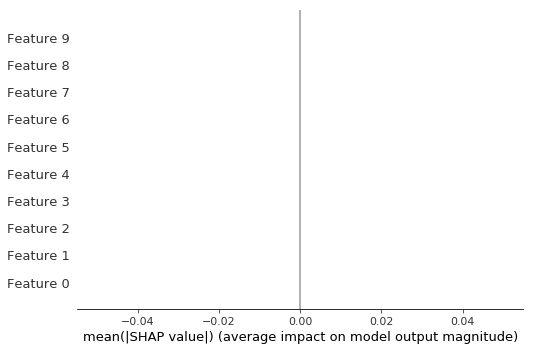

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.25536119 -1.17252063  0.6752068  ...  2.00715664  0.13150665
   0.        ]
 [ 0.25536119  0.29680347  0.6752068  ...  0.51151086  0.13150665
   0.        ]
 [-1.19555466  0.29680347  0.6752068  ... -0.98413493  0.13150665
   0.        ]
 ...
 [ 0.25536119  1.76612756  0.6752068  ...  0.51151086  0.13150665
   0.        ]
 [-1.19555466  1.76612756 -1.09235027 ... -0.98413493  0.13150665
   0.        ]
 [ 0.25536119  0.29680347 -2.85990734 ...  0.51151086  0.13150665
   0.        ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [31]:
samples_n = 1000
loci_m = 10
beta_g = 1
e_noise = 0
unfinished = True
while unfinished:
        G, loci = simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise)
        shap_values, x_train, x_test, y_train, y_test, y_predict, forReg = shap_RFR_tree_train(G, 'all')
        max_holder = max_mean_feature(shap_values)
        if max_holder[0] == loci:
            unfinished = True
        else:
            unfinished = False

print("Length G")
print(len(G))
print("Length G[0]")
print(len(G[0]))
print("Causal Loci")
print(loci)
print("SHAP selected causal loci")
print(max_holder[0])
#print(shap_values)
#print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2)) 
#print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
#print("Root Mean squared error =", sqrt(round(metrics.mean_squared_error(y_test, y_predict), 2)))
#print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
#print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
#print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))
shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")
print(shap_values)
print(G)
print(y_predict)

In [32]:
print(G[0:10])

[[ 0.25536119 -1.17252063  0.6752068   0.62765347  1.00313683  0.4243281
  -2.61028923  0.          2.00715664  0.13150665  0.        ]
 [ 0.25536119  0.29680347  0.6752068   0.62765347  1.00313683  0.4243281
   0.369493    0.          0.51151086  0.13150665  0.        ]
 [-1.19555466  0.29680347  0.6752068  -1.28010784  1.00313683  0.4243281
   0.369493    0.         -0.98413493  0.13150665  0.        ]
 [-1.19555466  0.29680347 -1.09235027  0.62765347 -0.50081644  0.4243281
   0.369493    0.         -0.98413493  0.13150665  0.        ]
 [ 1.70627703  0.29680347  0.6752068   0.62765347 -2.0047697  -2.19498116
   0.369493    0.         -0.98413493  0.13150665  0.        ]
 [-1.19555466  0.29680347 -1.09235027  0.62765347  1.00313683  0.4243281
   0.369493    0.          0.51151086  0.13150665  0.        ]
 [ 0.25536119  0.29680347 -1.09235027 -1.28010784  1.00313683  0.4243281
   0.369493    0.         -0.98413493  0.13150665  0.        ]
 [-1.19555466  0.29680347  0.6752068   0.627653

In [33]:
counter = 0
for row in G:
    if row[7] == 0:
        counter += 1
        
print(counter)

1000


In [ ]:
#Causal loci feature frequency fixed? problem
#Try setting matrix range from 0.1 to 0.9

In [25]:
print(shap_values)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [21]:
samples_n = 100
loci_m = 10
beta_g = 1
e_noise = 0
unfinished = True
while unfinished:
        G, loci = simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise)
        shap_values, x_train, x_test, y_train, y_test, y_predict, forReg = shap_RFR_tree_train(G)
        max_holder = max_mean_feature(shap_values)
        if max_holder[0] == loci:
            unfinished = True
        else:
            unfinished = False

print("Length G")
print(len(G))
print("Length G[0]")
print(len(G[0]))
print("Causal Loci")
print(loci)
print("SHAP selected causal loci")
print(max_holder[0])
#print(shap_values)
#print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2)) 
#print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
#print("Root Mean squared error =", sqrt(round(metrics.mean_squared_error(y_test, y_predict), 2)))
#print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
#print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
#print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))
shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")
print(shap_values)

Y predict
[-0.57947386 -0.57947386 -0.57947386 -0.57947386 -0.57947386  1.56672563
 -0.57947386 -0.57947386 -0.57947386 -0.57947386  1.56672563  1.56672563
  2.16766149 -0.57947386 -0.57947386 -0.57947386 -0.57947386 -0.57947386
 -0.57947386 -0.57947386 -0.57947386 -0.57947386 -0.57947386 -0.57947386
 -0.57947386  1.56672563 -0.57947386 -0.57947386  1.56672563 -0.57947386
 -0.57947386 -0.57947386  1.56672563 -0.57947386 -0.57947386  1.56672563
 -0.57947386 -0.57947386 -0.57947386  1.56672563 -0.57947386 -0.57947386
  1.65257361 -0.57947386  1.65257361 -0.57947386 -0.57947386 -0.57947386
 -0.57947386 -0.57947386  1.56672563 -0.57947386 -0.57947386 -0.57947386
 -0.57947386 -0.57947386  1.56672563  3.02614129 -0.57947386  1.56672563
 -0.57947386 -0.57947386  1.56672563 -0.57947386  1.56672563  1.56672563
 -0.57947386 -0.57947386 -0.57947386  1.56672563 -0.57947386 -0.57947386
  1.56672563 -0.57947386 -0.57947386 -0.57947386 -0.57947386 -0.57947386
  1.56672563 -0.57947386  1.56672563 -0.5

ValueError: not enough values to unpack (expected 7, got 2)

In [26]:
samples_n = 100
loci_m = 10
beta_g = 1
e_noise = 0
unfinished = True
while unfinished:
        G, loci = simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise)
        shap_values, x_train, x_test, y_train, y_test, y_predict, forReg = shap_RFR_tree_train(G)
        max_holder = max_mean_feature(shap_values)
        if max_holder[0] == loci:
            unfinished = True
        else:
            unfinished = False

print("Length G")
print(len(G))
print("Length G[0]")
print(len(G[0]))
print("Causal Loci")
print(loci)
print("SHAP selected causal loci")
print(max_holder[0])
#print(shap_values)
#print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2)) 
#print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
#print("Root Mean squared error =", sqrt(round(metrics.mean_squared_error(y_test, y_predict), 2)))
#print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
#print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
#print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))
shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")
print(shap_values)

Y predict
[ 0.89811699 -0.59625404 -0.59625404 -0.59625404  0.89811699 -0.59625404
  0.89811699  0.89811699  0.89811699  0.89811699 -0.59625404  0.89811699
  0.89811699 -0.59625404 -2.09062507  0.89811699  0.89811699  0.89811699
 -0.59625404  0.89811699  0.89811699 -0.59625404  0.89811699 -0.59625404
  0.89811699  0.89811699  0.89811699 -2.09062507 -0.59625404  0.89811699
  0.89811699 -0.59625404  0.89811699  0.89811699 -0.59625404 -0.59625404
 -0.59625404  0.89811699  0.89811699 -2.09062507 -0.59625404  0.89811699
  0.89811699 -0.59625404  0.89811699 -2.09062507  0.89811699  0.89811699
 -0.59625404  0.89811699  0.89811699 -0.59625404  0.89811699 -0.59625404
 -2.09062507 -2.09062507 -2.09062507 -0.59625404  0.89811699 -0.59625404
 -2.09062507 -0.59625404 -2.09062507 -2.09062507  0.89811699 -0.59625404
 -0.59625404  0.89811699  0.89811699  0.89811699 -0.59625404  0.89811699
  0.89811699  0.89811699 -0.59625404 -0.59625404  0.89811699 -0.59625404
 -0.59625404 -0.59625404 -0.59625404 -0.5

 -0.59625404  0.89811699  0.89811699  0.89811699]


ValueError: not enough values to unpack (expected 7, got 2)

In [32]:
def shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise, number_trials, confidence = 0.95, test = 'N'):
    shap_values_SNP = []
    counter = 0
    shap_9 = []
    shap_8 = []
    shap_unknown = []
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise)
        if test == 'N':
            shap_values_holder, x_train = shap_RFR_tree_train(G)
        elif test == 'Y':    
            shap_values_holder, x_train, x_test, y_train, y_test, y_predict, forReg = shap_RFR_tree_train(G, 'all')
        max_holder = max_mean_feature(shap_values_holder)
        if max_holder[0] == loci:
            shap_values_SNP.append(1)
        else:
            shap_values_SNP.append(0)
            if loci == 9:
                shap_9.append((loci, shap_values_holder))
            elif max_holder[0] == 8:
                shap_8.append((loci, shap_values_holder))
            else:
                shap_unknown.append((loci, shap_values_holder, max_holder[0]))
                
        counter += 1
    
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    
    n = len(shap_values_SNP)
    m = mean(shap_values_SNP)
    std_err = sem(shap_values_SNP)
    confidence_int = std_err * t.ppf((1 + confidence) / 2, n - 1)
    
    if test == 'N':
        return percent, confidence_int
    elif test == 'Y':
        return percent, confidence_int, shap_9, shap_8, shap_unknown

In [33]:
percent, confidence_int, shap_9, shap_8, shap_unknown = shap_acc_RFR_set(100, 10, 1, 0, 100, 0.95,'Y')
print(percent)
print(len(shap_9))
print(len(shap_8))
print(len(shap_unknown))

99.0
0
0
1


In [35]:
percent, confidence_int, shap_9, shap_8, shap_unknown = shap_acc_RFR_set(100, 10, 1, 0, 100, 0.95, 'Y')
print(percent)
print(len(shap_9))
print(len(shap_8))
print(len(shap_unknown))

100.0
0
0
0


In [102]:
percent_t = 0
shap_9_t = 0
shap_8_t = 0
shap_unknown_t = 0
counter =  0
while not counter == 100:
    percent, confidence_int, shap_9, shap_8, shap_unknown = shap_acc_RFR_set(100, 10, 1, 0, 100, confidence = 0.95)
    percent_t += percent
    shap_9_t += len(shap_9)
    shap_8_t += len(shap_8)
    shap_unknown_t += len(shap_unknown)
    counter += 1
print(percent_t / 100)
print(shap_9_t / 100)
print(shap_8_t / 100)
print(shap_unknown_t / 100)

89.53
9.33
1.13
0.01


In [103]:
print(percent_t)
print(percent)

8953.0
89.0
